**Import Libraries**

In [32]:
# Import libraries
import os
import pandas as pd
import requests
import zipfile
import io
import inspect
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
import textwrap

**Download and Unpack Source Data File**

In [33]:
# Define the URL of the ZIP file
url = 'https://github.com/lior-emuna/voting-predictions/raw/main/Resources.zip'

# Download the ZIP file
response = requests.get(url)

# Create a directory to unpack the contents
unpack_dir = '/content'
os.makedirs(unpack_dir, exist_ok=True)

# Unpack the ZIP file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(unpack_dir)

Utility Functions

In [34]:
# Utility functions

def remove_quotes(x):
    return x.replace("'", "").replace('"', '')

**Data Transformation and Handling Functions**

In [35]:
def trans_semel(semel_yeshuv):
    while semel_yeshuv < 1000:
        semel_yeshuv = semel_yeshuv * 10
    semel_yeshuv = semel_yeshuv * 10000
    return semel_yeshuv

def handle_stat_columns(stat_file):
    kalpi = stat_file.columns[stat_file.columns.str.contains('קלפי')][0]
    stat = stat_file.columns[stat_file.columns.str.contains('סטטיסטי')][0]
    semel = stat_file.columns[stat_file.columns.str.contains('סמל')][0]
    shem = stat_file.columns[stat_file.columns.str.contains('שם')][0]
    stat_file.rename(columns={semel: 'סמל ישוב',
                              shem: 'שם ישוב',
                              kalpi: 'קלפי',
                              stat: 'CODE_OF_STATISTICAL_AREA'},
                     inplace=True)
    cols_to_keep = ['סמל ישוב', 'קלפי', 'CODE_OF_STATISTICAL_AREA']
    stat_file = stat_file.filter(items=cols_to_keep)
    return stat_file

def handle_res_columns(res_file):
    res_file.columns = res_file.columns.map(remove_quotes)
    columns_to_drop = ['סמל ועדה', 'ברזל', 'שופט', 'ריכוז']
    res_file.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    try:
        voters = res_file.columns[res_file.columns.str.contains('ב.*ח.*ר', regex=True)][0]
    except IndexError:
        voters = res_file.columns[res_file.columns.str.contains('בזב', regex=True)][0]
    kalpi = res_file.columns[res_file.columns.str.contains('קלפי')][0]
    res_file.rename(columns={voters: 'בזב', kalpi: 'קלפי'}, inplace=True)

    na_columns = res_file.filter(like='Unnamed').columns.tolist()
    if len(na_columns) > 0:
        res_file = res_file.drop(columns=na_columns)

    res_file = res_file.dropna()
    res_file.loc[:, 'קלפי'] = res_file['קלפי'].astype(int)

    column_types = res_file.dtypes
    datetime_columns = column_types[column_types == 'datetime64[ns]'].index
    if len(datetime_columns) > 0:
        res_file = res_file.drop(columns=datetime_columns)
    return res_file

**Data Aggregation and Merging Functions**

In [36]:
def get_kalpi_results(resFile, statFile):
    fname, extention = os.path.splitext(os.path.basename(resFile))
    if extention == '.csv':
        try:
            with open(resFile, 'rb') as f:
                kalpi_results = pd.read_csv(f, encoding='iso-8859-8')
        except UnicodeDecodeError:
            kalpi_results = pd.read_csv(resFile, encoding='utf-8')
    else:
        kalpi_results = pd.read_excel(resFile)
    kalpi_results = handle_res_columns(kalpi_results)

    kalpiStat = pd.read_excel(statFile)
    kalpiStat = handle_stat_columns(kalpiStat)

    kalpi_results_stat = pd.merge(kalpi_results, kalpiStat, on=['סמל ישוב', 'קלפי'], how='left')
    kalpi_results_stat['CODE_OF_STATISTICAL_AREA'] = kalpi_results_stat['CODE_OF_STATISTICAL_AREA'].fillna(-1)
    kalpi_results_stat.drop(columns=['קלפי'], inplace=True)

    groupby = ['סמל ישוב', 'CODE_OF_STATISTICAL_AREA']
    agg_funcs = {}
    for col in kalpi_results_stat.columns:
        if 'שם ישוב' in col:
            agg_funcs[col] = 'first'
        elif col not in ['סמל ישוב', 'CODE_OF_STATISTICAL_AREA']:
            agg_funcs[col] = 'sum'
    kalpi_results_stat_agg = kalpi_results_stat.groupby(groupby).agg(agg_funcs).reset_index()

    kalpi_results_stat_agg['source'] = fname
    kalpi_results_stat_agg_merged = include_cbs_data(kalpi_results_stat_agg)
    columns_to_drop = ['שם ישוב', 'שם_יישוב', 'סמל ישוב']
    kalpi_results_stat_agg_merged.columns = kalpi_results_stat_agg_merged.columns.str.strip()
    kalpi_results_stat_agg_merged.drop(columns=columns_to_drop, inplace=True)
    return kalpi_results_stat_agg_merged

def include_cbs_data(voting_result):
    if voting_result['source'][0].lstrip('results_') == '20':
        cbs = pd.read_excel('/content/Resources/cbs-transformed/socio_economic_scale_t1+t7+t12_2017.xlsx')
    else:
        cbs = pd.read_excel('/content/Resources/cbs-transformed/socio_economic_scale_t1+t7+t12_2019.xlsx')
    merged_result = pd.merge(voting_result, cbs,
                             left_on=['סמל ישוב', 'CODE_OF_STATISTICAL_AREA'],
                             right_on=['CODE_OF_LOCALITY', 'CODE_OF_STATISTICAL_AREA'],
                             how='inner')
    return merged_result


**Functions for Handling Voting Data**

In [37]:
def get_all_vote_data(save=True):
    kalpi_votes = "/content/Resources/kalpi_votes/"
    kalpi_stat = "/content/Resources/kalpi_stat/"
    all_files = []
    for kalpi_votes_file, kalpi_stat_file in zip(sorted(os.listdir(kalpi_votes)), sorted(os.listdir(kalpi_stat))):
        kalpi_votes_path = os.path.join(kalpi_votes, kalpi_votes_file)
        kalpi_stat_path = os.path.join(kalpi_stat, kalpi_stat_file)
        res_file = get_kalpi_results(kalpi_votes_path, kalpi_stat_path)
        all_files.append(res_file)
        if save:
            fname = res_file['source'][0]
            res_file.to_excel(f'{fname}.xlsx', index=False)
    return all_files

def get_single_vote_data(vote, stat, save=True):
    kalpi_votes = f'/content/Resources/kalpi_votes/{vote}'
    kalpi_stat = f'/content/Resources/kalpi_stat/{stat}'
    res_file = get_kalpi_results(kalpi_votes, kalpi_stat)
    return res_file

def calculate_voting_percentage(data):
  data['Voting precantage'] = data['מצביעים'] / data['בזב']
  data['Voting precantage'] = np.round(data['Voting precantage'], 2)
  return data


**Functions for Handling Religion Data**

In [38]:
def split_and_merge_religion_data(data):
    # Split the religion table
    religion = pd.read_excel('/content/Resources/cbs-transformed/religion_spread_by_stat_codes_2019.xlsx')
    religion_total = religion[religion['אזור סטטיסטי'] == 'סה"כ']
    religion_specific = religion[religion['אזור סטטיסטי'] != 'סה"כ']

    # Perform a normal merge for specific areas
    merged_specific = pd.merge(
        data,
        religion_specific,
        left_on=['CODE_OF_LOCALITY', 'CODE_OF_STATISTICAL_AREA'],
        right_on=['סמל יישוב', 'אזור סטטיסטי']
    )

    # Merge with 'סה"כ' rows
    merged_total = pd.merge(
        data,
        religion_total.drop(columns=['אזור סטטיסטי']),  # drop the column as it is not needed in merge
        left_on=['CODE_OF_LOCALITY'],
        right_on=['סמל יישוב']
    )

    # Combine the results
    final_merged = pd.concat([merged_specific, merged_total], ignore_index=True)

    return final_merged

def add_max_column_and_encode(final_merged):
    # Define the function to get the max column
    def get_max_column(row):
        max_value = None
        max_column = None
        for column in row.index:
            if max_value is None or row[column] > max_value:
                max_value = row[column]
                max_column = column
        return max_column

    # Create a new column called "Religion" in the DataFrame
    new_column_names = {
    'יהודים%': '%JEWS',
    'מוסלמים%': '%MUSLIMS',
    'נוצרים ערבים%': '%CHRISTIAN ARABS',
    'נוצרים לא-ערבים%': '%CHRISTIAN NON-ARABS',
    'דרוזים%': '%DRUZE',
    'ללא סיווג דת%': '%UNCLASSIFIED'}
    final_merged.rename(columns=new_column_names, inplace=True)
    columns_to_check = ['%JEWS', '%MUSLIMS', '%CHRISTIAN ARABS', '%CHRISTIAN NON-ARABS', '%DRUZE', '%UNCLASSIFIED']
    # Apply the function to the DataFrame
    final_merged['Religion-'] = final_merged[columns_to_check].apply(get_max_column, axis=1)

    # Perform one-hot encoding on "Religion"
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    max_column_data = final_merged["Religion-"].values.reshape(-1, 1)
    encoded_data = pd.DataFrame(ohe.fit_transform(max_column_data), columns=ohe.get_feature_names_out(["Religion-"]))

    # Join the encoded data with the original DataFrame
    final_merged = pd.concat([final_merged, encoded_data], axis=1)

    return final_merged


**Functions for Handling Missing Values**

In [39]:
def handle_missing_values(dataset):
    columns_with_mode = [col for col in dataset.columns if 'RANK' in col]
    columns_with_mode += [col for col in dataset.columns if 'STANDARDIZED' in col]
    columns_with_mode += [col for col in dataset.columns if 'VALUE' in col]
    for i in range(1, 11):
        selected = dataset[dataset['_SOCIO_ECONOMIC_INDEX_-CLUSTER'] == i]
        for col in columns_with_mode:
            selected.loc[:, col] = pd.to_numeric(selected[col], errors='coerce')
            mean_col = selected[col].mean()
            selected.loc[:, col] = selected[col].fillna(mean_col)

        dataset.update(selected)
    return dataset

def get_train_and_test(train, test, save=True):
    kalpi_votes = "/content/Resources/kalpi_votes/"
    kalpi_stat = "/content/Resources/kalpi_stat/"
    for kalpi_votes_file, kalpi_stat_file in zip(sorted(os.listdir(kalpi_votes)), sorted(os.listdir(kalpi_stat))):
        kalpi_votes_path = os.path.join(kalpi_votes, kalpi_votes_file)
        kalpi_stat_path = os.path.join(kalpi_stat, kalpi_stat_file)
        res_file = get_kalpi_results(kalpi_votes_path, kalpi_stat_path)
        if res_file['source'][0].lstrip('results_') == '25':
            test = res_file
        else:
            train = pd.concat([train, res_file], ignore_index=True, join='outer')

    train = handle_missing_values(train)
    test = handle_missing_values(test)

    train = add_max_column_and_encode(split_and_merge_religion_data(train))
    test = add_max_column_and_encode(split_and_merge_religion_data(test))

    train = calculate_voting_percentage(train)
    test = calculate_voting_percentage(test)

    if save:
        train.to_excel('train.xlsx', index=False)
        test.to_excel('test.xlsx', index=False)
    return train, test


In [40]:
train, test = get_train_and_test(pd.DataFrame(), pd.DataFrame())

Prepare Train Data

In [41]:
data = train.copy()
all_columns = data.columns
all_columns = [col for col in all_columns if not col.startswith('_SOCIO_ECONOMIC_INDEX')]
value_columns = [col for col in all_columns if col.endswith('-VALUE')]
standardized_value_columns = [col for col in all_columns if col.endswith('-STANDARDIZED_VALUE')]
rank_columns = [col for col in all_columns if col.endswith('-RANK')]
religion_columns = [col for col in all_columns if col.endswith('%')]
religion_oneHot = [col for col in all_columns if col.startswith('Religion-_')]

**Descriptive Statistics**

Correlation with Voting Percentage:
 EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-RANK                  0.581803
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-STANDARDIZED_VALUE                                                                  0.571850
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-VALUE                                                                               0.564955
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-RANK                                                                                0.564512
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-STANDARDIZED_VALUE    0.556906
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AGED_25_54_WITH_NO_INCOME_FROM_WORK-RANK                                                                  0.515437
EMPLOYMEN

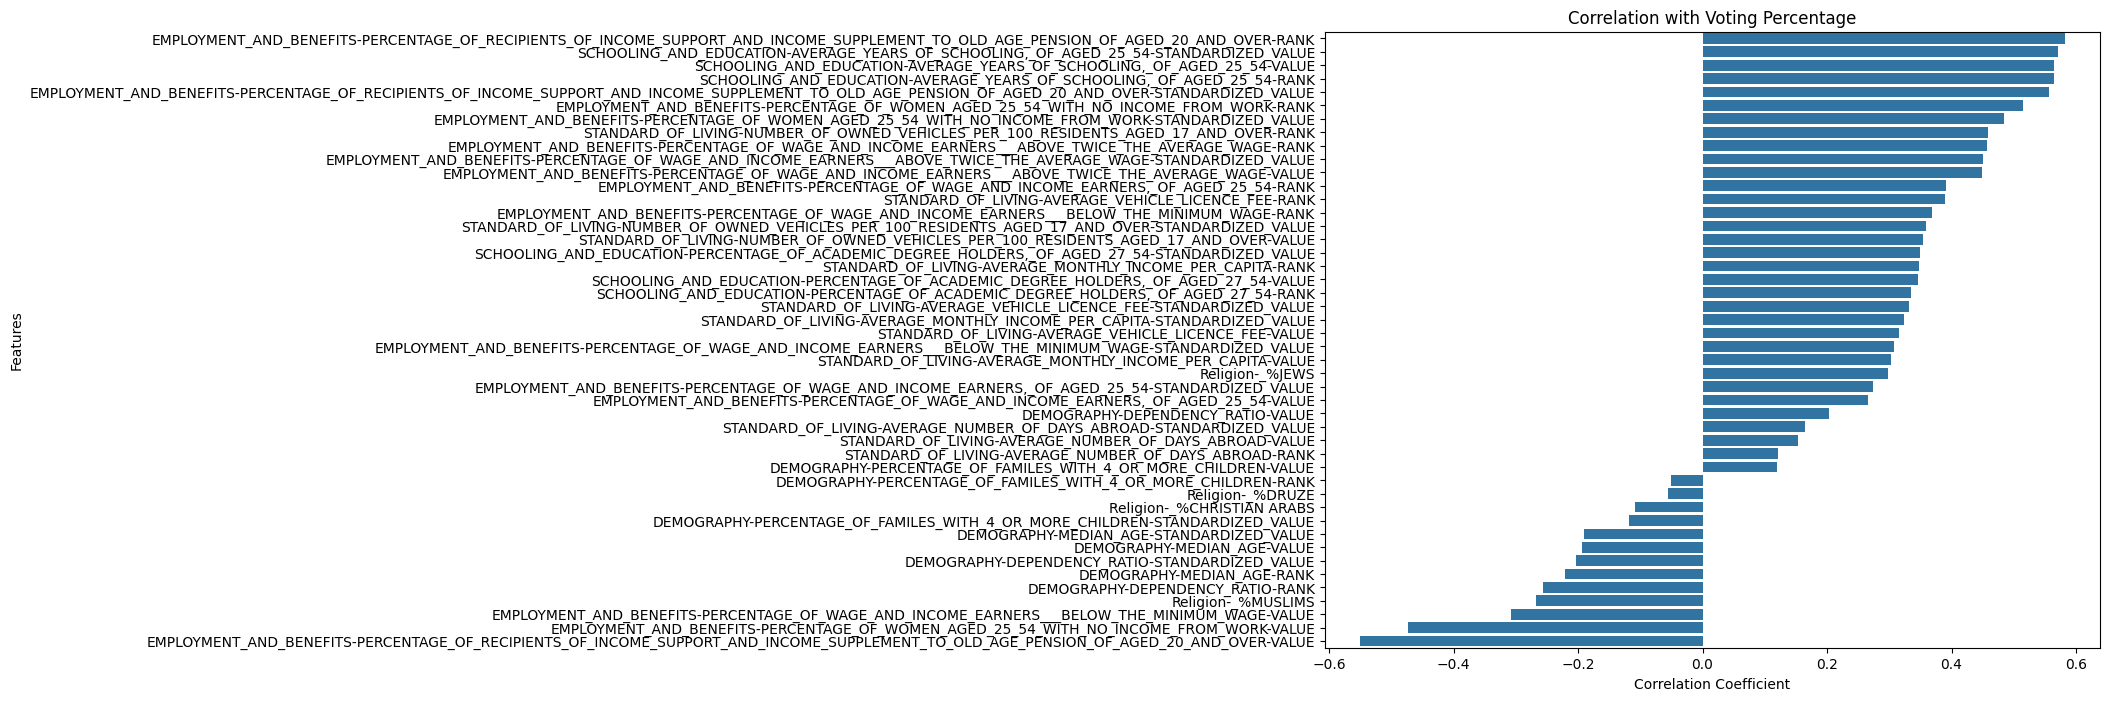

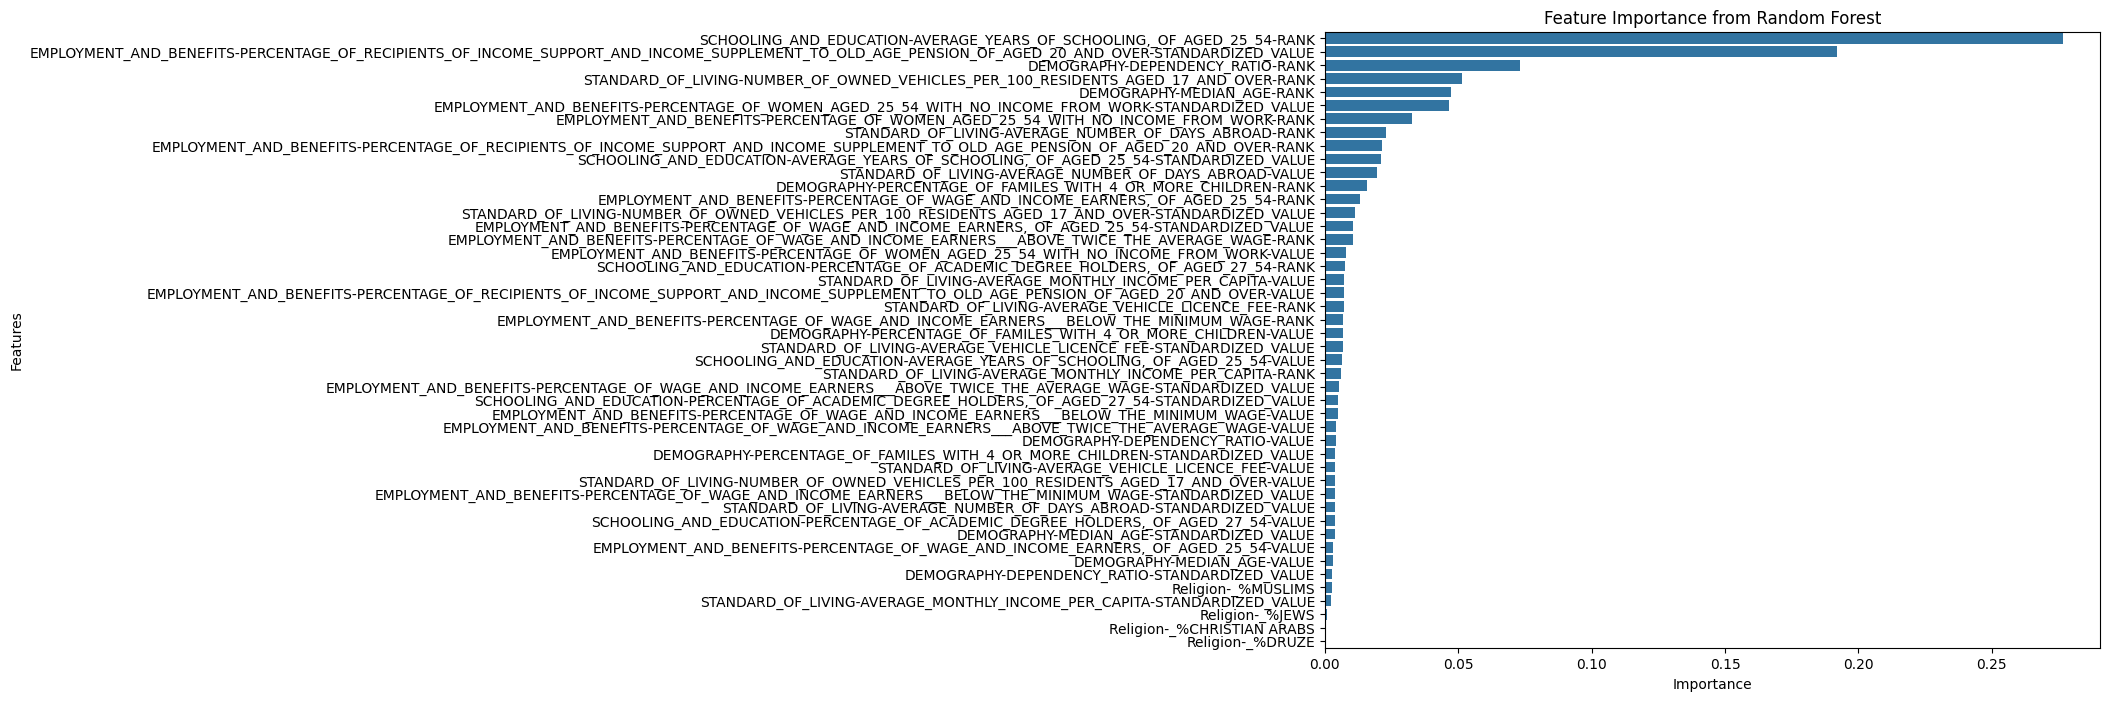

ANOVA F-test scores:
 EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-RANK                  4021.485487
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-STANDARDIZED_VALUE                                                                  3818.778455
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-VALUE                                                                               3684.336878
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-RANK                                                                                3675.858116
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-STANDARDIZED_VALUE    3533.239589
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-VALUE                 3410.941684
EMPLOY

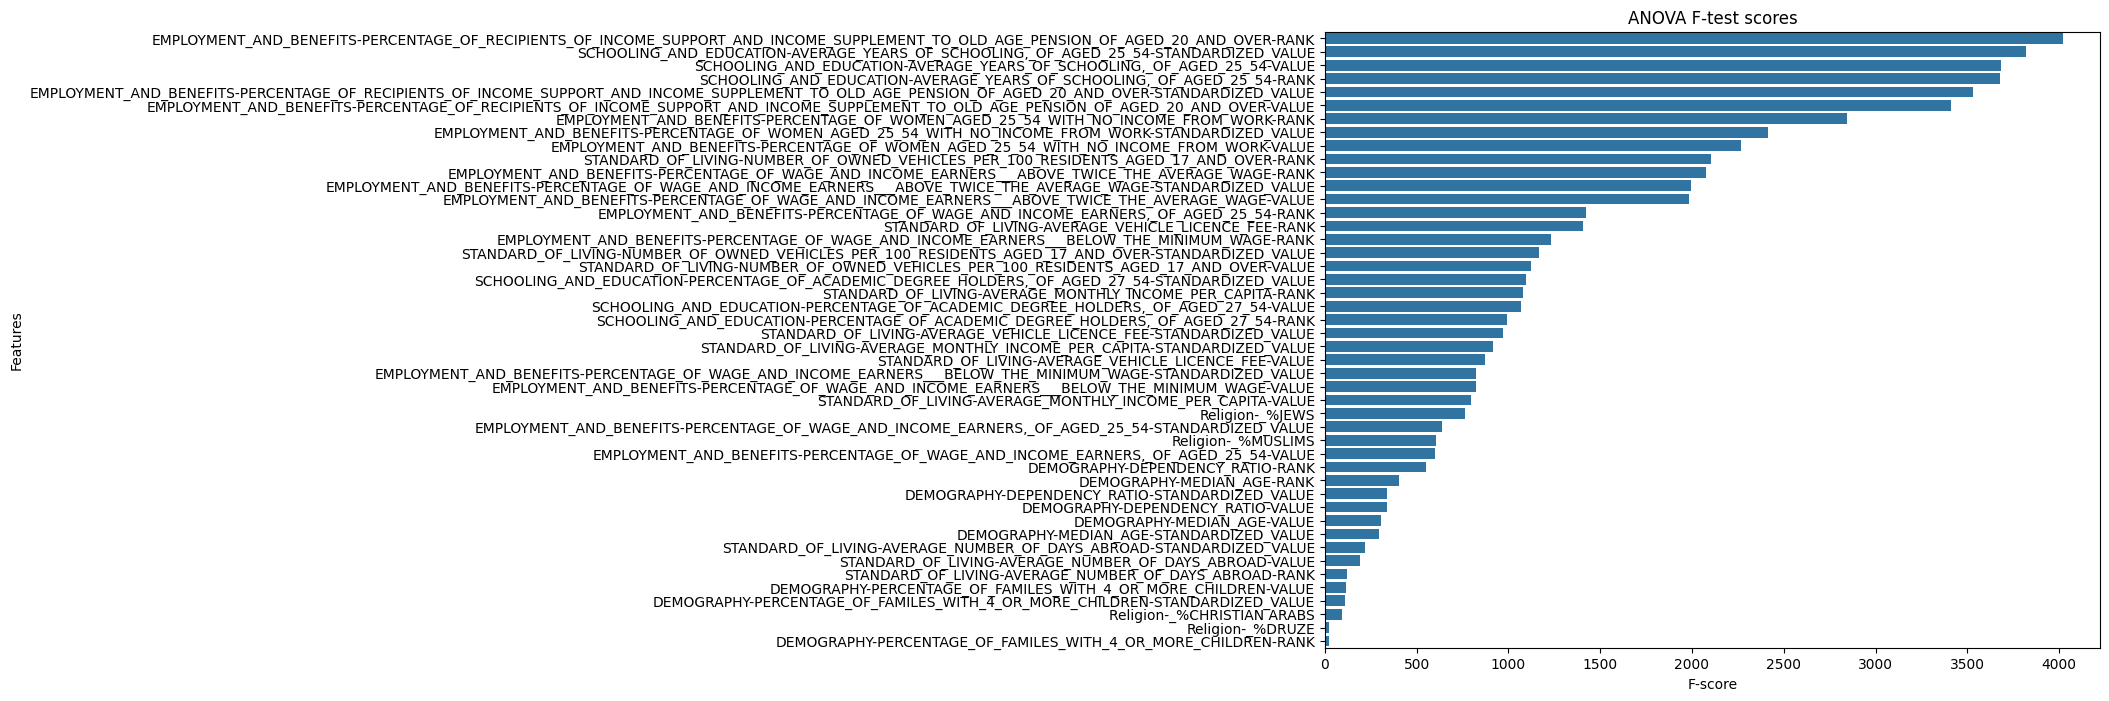

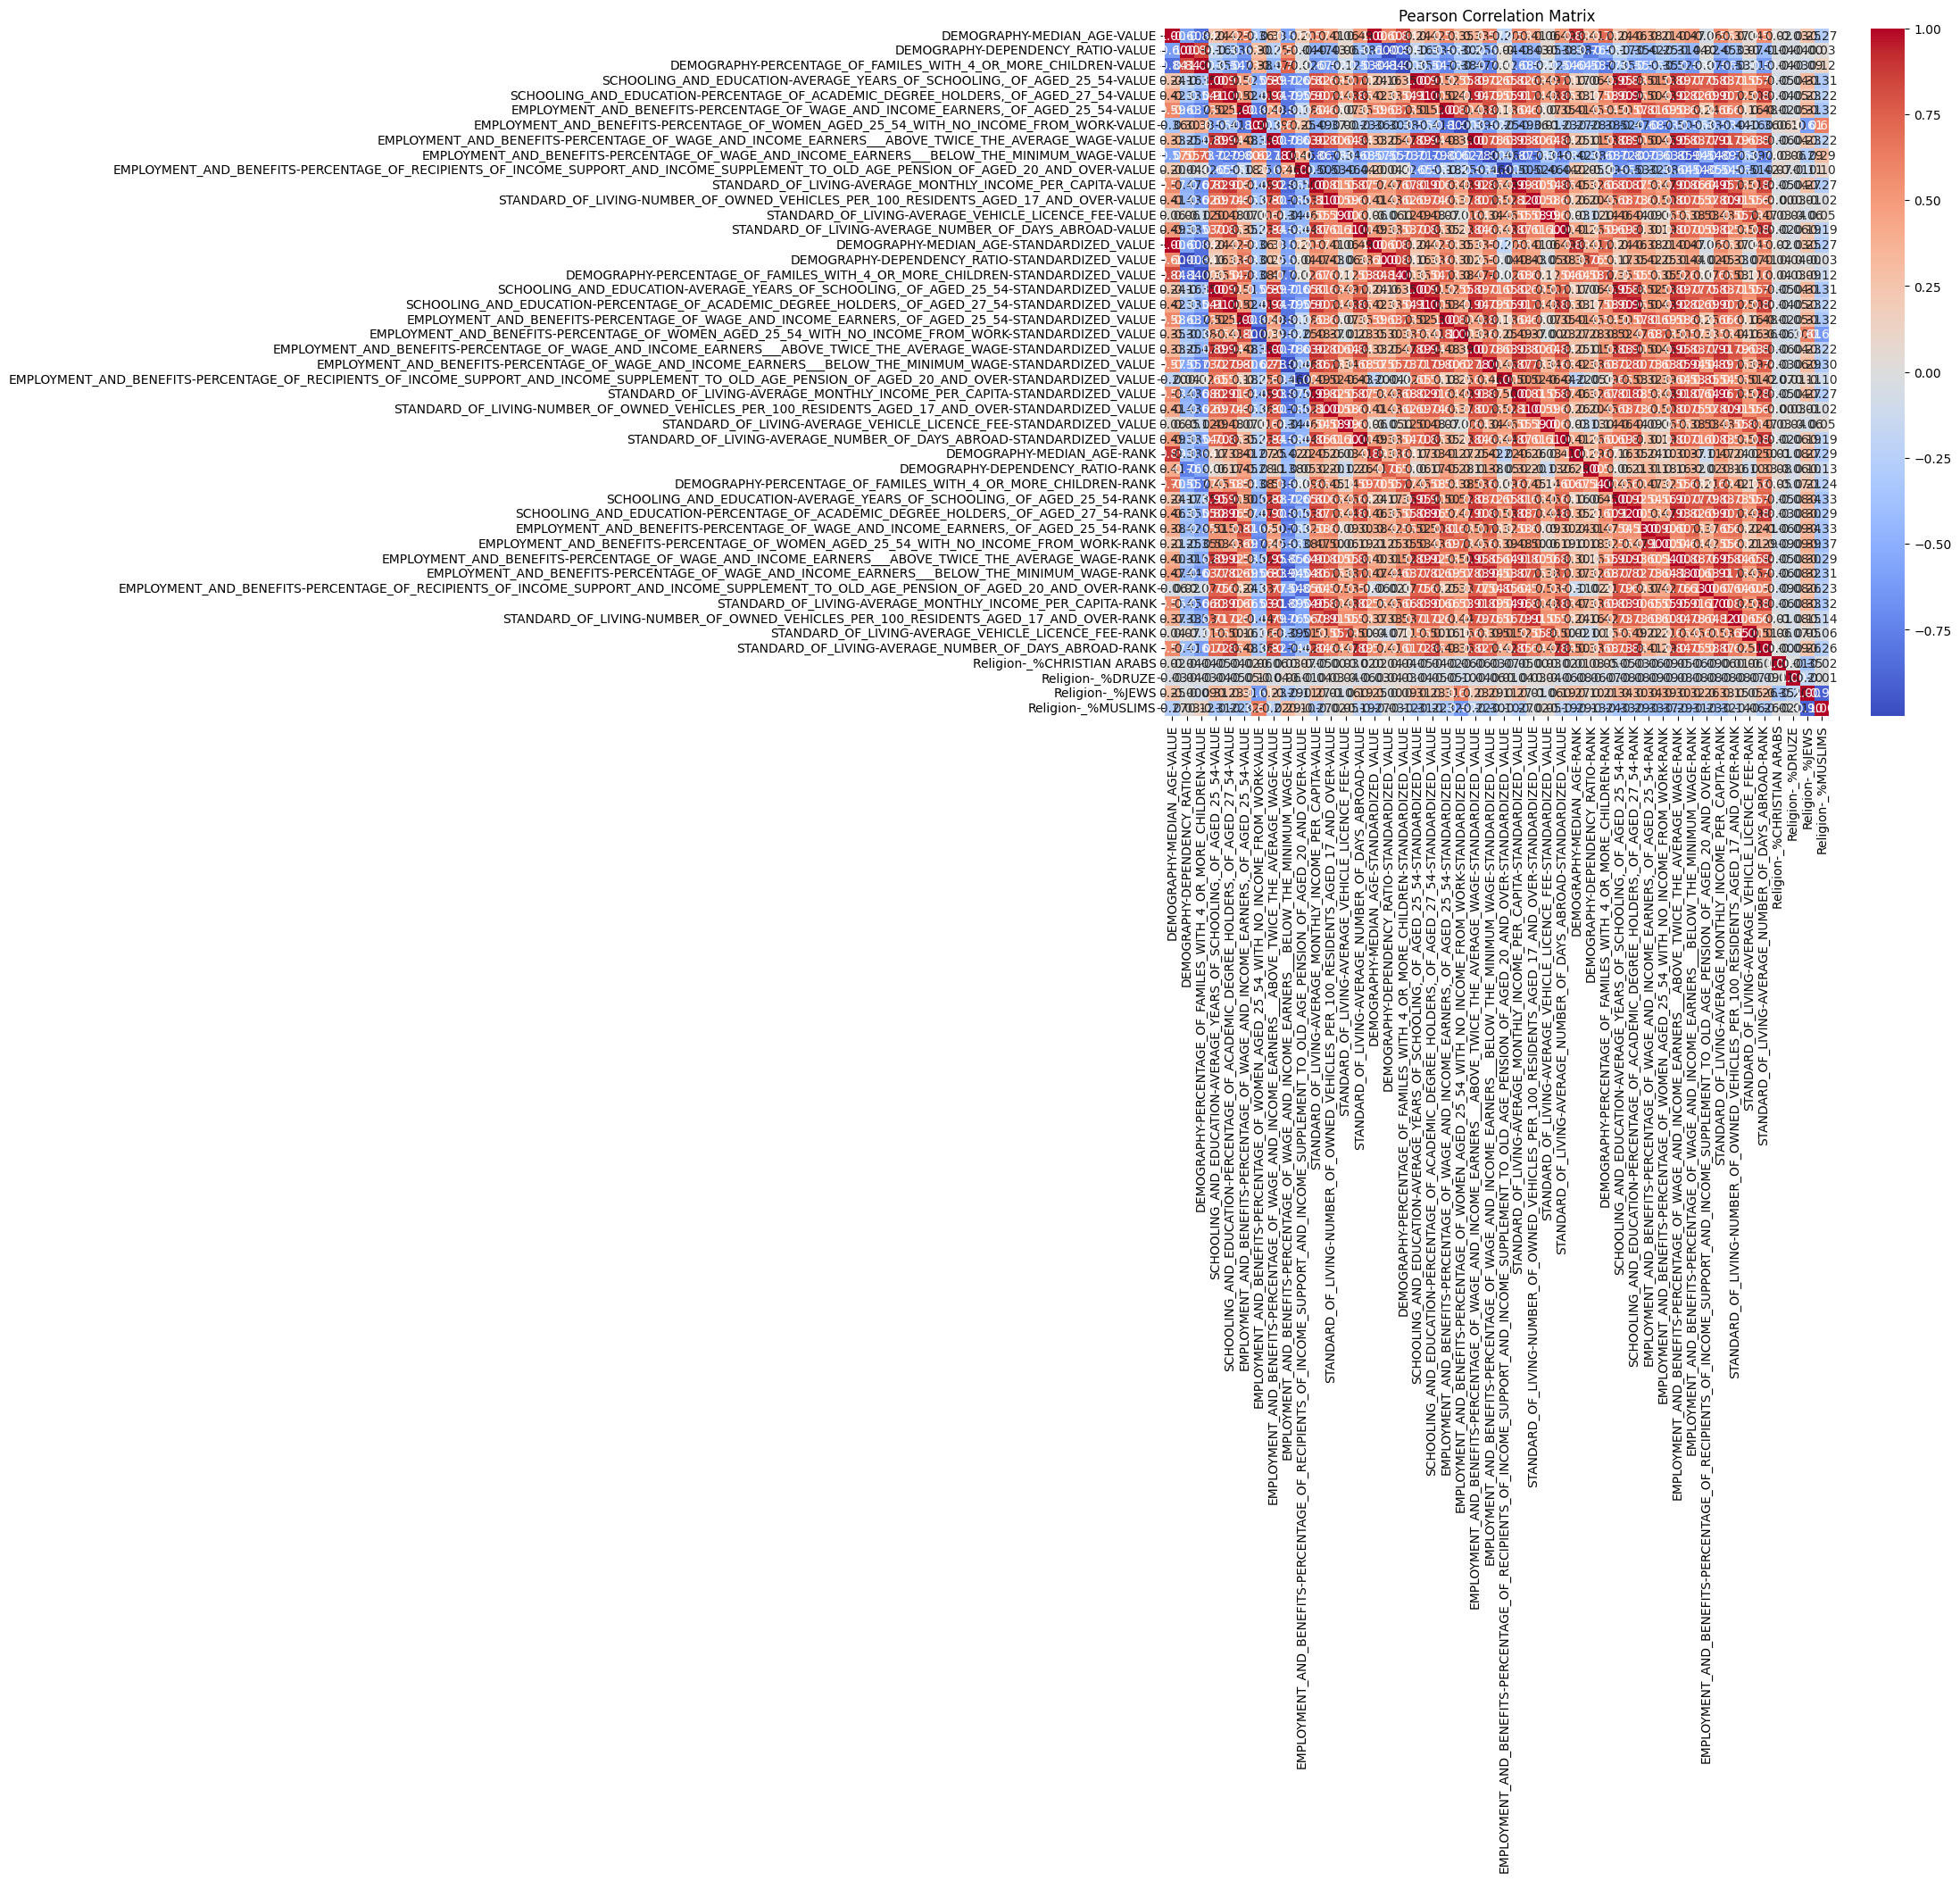

In [42]:
required_columns = value_columns + standardized_value_columns + rank_columns + religion_oneHot

# Prepare the data
X = data[required_columns]
y = data['Voting precantage']

# Compute correlation matrix
correlation_matrix = X.corrwith(y).sort_values(ascending=False)
print("Correlation with Voting Percentage:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index)
plt.title('Correlation with Voting Percentage')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Feature importance using Random Forest
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# ANOVA F-test scores
f_scores, p_values = f_regression(X, y)
f_scores_series = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)
p_values_series = pd.Series(p_values, index=X.columns).sort_values(ascending=False)

print("ANOVA F-test scores:\n", f_scores_series)
print("p-values:\n", p_values_series)

# Plot ANOVA F-test scores
plt.figure(figsize=(10, 8))
sns.barplot(x=f_scores_series.values, y=f_scores_series.index)
plt.title('ANOVA F-test scores')
plt.xlabel('F-score')
plt.ylabel('Features')
plt.show()

# Calculate Pearson correlation matrix
correlation_matrix = X.corr(method='pearson')

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.show()



Function for evaluating models

In [ ]:
def get_variable_name(var):
    name = [name for name in globals() if globals()[name] is var]
    return name[0].replace('_', ' ') if name else None

def evaluate_model(model, X_train, X_val, y_train, y_val):
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    train_adj_r2 = 1 - (1 - train_r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
    train_std = np.std(train_predictions - y_train)

    val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_r2 = r2_score(y_val, val_predictions)
    val_adj_r2 = 1 - (1 - val_r2) * ((X_val.shape[0] - 1) / (X_val.shape[0] - X_val.shape[1] - 1))
    val_std = np.std(val_predictions - y_val)

    model_name = get_variable_name(model)
    print(f"{model_name} Results:")
    print(f"Training Set RMSE: {train_rmse}")
    print(f"Training Set MAE: {train_mae}")
    print(f"Training Set R-squared: {train_r2}")
    print(f"Training Set Adjusted R-squared: {train_adj_r2}")
    print(f"Training Set Standard Deviation: {train_std}")
    print(f"Validation Set RMSE: {val_rmse}")
    print(f"Validation Set MAE: {val_mae}")
    print(f"Validation Set R-squared: {val_r2}")
    print(f"Validation Set Adjusted R-squared: {val_adj_r2}")
    print(f"Validation Set Standard Deviation: {val_std}")
    print("\n")


    return train_rmse, train_mae, train_r2, train_adj_r2, train_std, val_rmse, val_mae, val_r2, val_adj_r2, val_std

**Models**

In [ ]:
X_value = data[value_columns + religion_oneHot]
X_standardized_value = data[standardized_value_columns + religion_oneHot]
X_rank = data[rank_columns + religion_oneHot]
y = data['Voting precantage']

X_value_train, X_value_val, y_train, y_val = train_test_split(X_value, y, test_size=0.2, random_state=42)
X_standardized_value_train, X_standardized_value_val, _, _ = train_test_split(X_standardized_value, y, test_size=0.2, random_state=42)
X_rank_train, X_rank_val, _, _ = train_test_split(X_rank, y, test_size=0.2, random_state=42)

Linear Regression

In [ ]:
LR_model_value = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_value.fit(X_value_train, y_train)

LR_model_standardized_value = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_standardized_value.fit(X_standardized_value_train, y_train)

LR_model_rank = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_rank.fit(X_rank_train, y_train)

train_rmse_value, train_mae_value, train_r2_value, train_adj_r2_value, train_std_value, val_rmse_value, val_mae_value, val_r2_value, val_adj_r2_value, val_std_value = evaluate_model(LR_model_value, X_value_train, X_value_val, y_train, y_val)
train_rmse_standardized_value, train_mae_standardized_value, train_r2_standardized_value, train_adj_r2_standardized_value, train_std_standardized_value, val_rmse_standardized_value, val_mae_standardized_value, val_r2_standardized_value, val_adj_r2_standardized_value, val_std_standardized_value = evaluate_model(LR_model_standardized_value, X_standardized_value_train, X_standardized_value_val, y_train, y_val)
train_rmse_rank, train_mae_rank, train_r2_rank, train_adj_r2_rank, train_std_rank, val_rmse_rank, val_mae_rank, val_r2_rank, val_adj_r2_rank, val_std_rank = evaluate_model(LR_model_rank, X_rank_train, X_rank_val, y_train, y_val)


Decision Tree

In [46]:
# Custom scoring function to calculate the standard deviation of residuals
def std_of_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    return np.std(residuals)

# Define custom scoring functions including standard deviation of residuals
scoring = {
    'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score),
    'std_of_residuals': make_scorer(std_of_residuals, greater_is_better=False)
}

# Step 4: Train the Decision Tree Models
tree_model_value = DecisionTreeRegressor(random_state=42)
tree_model_standardized_value = DecisionTreeRegressor(random_state=42)
tree_model_rank = DecisionTreeRegressor(random_state=42)

# Perform cross-validation
cv_results_value = cross_validate(tree_model_value, X_value_train, y_train, scoring=scoring, cv=5, return_train_score=True)
cv_results_standardized_value = cross_validate(tree_model_standardized_value, X_standardized_value_train, y_train, scoring=scoring, cv=5, return_train_score=True)
cv_results_rank = cross_validate(tree_model_rank, X_rank_train, y_train, scoring=scoring, cv=5, return_train_score=True)

# Extract mean scores from cross-validation results
train_rmse_tree_value = -np.mean(cv_results_value['train_neg_root_mean_squared_error'])
train_mae_tree_value = -np.mean(cv_results_value['train_neg_mean_absolute_error'])
train_r2_tree_value = np.mean(cv_results_value['train_r2'])
std_residuals_train_value = -np.mean(cv_results_value['train_std_of_residuals'])
val_rmse_tree_value = -np.mean(cv_results_value['test_neg_root_mean_squared_error'])
val_mae_tree_value = -np.mean(cv_results_value['test_neg_mean_absolute_error'])
val_r2_tree_value = np.mean(cv_results_value['test_r2'])
std_residuals_val_value = -np.mean(cv_results_value['test_std_of_residuals'])

train_rmse_tree_standardized_value = -np.mean(cv_results_standardized_value['train_neg_root_mean_squared_error'])
train_mae_tree_standardized_value = -np.mean(cv_results_standardized_value['train_neg_mean_absolute_error'])
train_r2_tree_standardized_value = np.mean(cv_results_standardized_value['train_r2'])
std_residuals_train_standardized_value = -np.mean(cv_results_standardized_value['train_std_of_residuals'])
val_rmse_tree_standardized_value = -np.mean(cv_results_standardized_value['test_neg_root_mean_squared_error'])
val_mae_tree_standardized_value = -np.mean(cv_results_standardized_value['test_neg_mean_absolute_error'])
val_r2_tree_standardized_value = np.mean(cv_results_standardized_value['test_r2'])
std_residuals_val_standardized_value = -np.mean(cv_results_standardized_value['test_std_of_residuals'])

train_rmse_tree_rank = -np.mean(cv_results_rank['train_neg_root_mean_squared_error'])
train_mae_tree_rank = -np.mean(cv_results_rank['train_neg_mean_absolute_error'])
train_r2_tree_rank = np.mean(cv_results_rank['train_r2'])
std_residuals_train_rank = -np.mean(cv_results_rank['train_std_of_residuals'])
val_rmse_tree_rank = -np.mean(cv_results_rank['test_neg_root_mean_squared_error'])
val_mae_tree_rank = -np.mean(cv_results_rank['test_neg_mean_absolute_error'])
val_r2_tree_rank = np.mean(cv_results_rank['test_r2'])
std_residuals_val_rank = -np.mean(cv_results_rank['test_std_of_residuals'])

# Display Results
print("Decision Tree (VALUE) Results:")
print("Training Set RMSE:", train_rmse_tree_value)
print("Training Set MAE:", train_mae_tree_value)
print("Training Set R-squared:", train_r2_tree_value)
print("Training Set Standard Deviation of Residuals:", std_residuals_train_value)
print("Validation Set RMSE:", val_rmse_tree_value)
print("Validation Set MAE:", val_mae_tree_value)
print("Validation Set R-squared:", val_r2_tree_value)
print("Validation Set Standard Deviation of Residuals:", std_residuals_val_value)

print("\nDecision Tree (STANDARDIZED_VALUE) Results:")
print("Training Set RMSE:", train_rmse_tree_standardized_value)
print("Training Set MAE:", train_mae_tree_standardized_value)
print("Training Set R-squared:", train_r2_tree_standardized_value)
print("Training Set Standard Deviation of Residuals:", std_residuals_train_standardized_value)
print("Validation Set RMSE:", val_rmse_tree_standardized_value)
print("Validation Set MAE:", val_mae_tree_standardized_value)
print("Validation Set R-squared:", val_r2_tree_standardized_value)
print("Validation Set Standard Deviation of Residuals:", std_residuals_val_standardized_value)

print("\nDecision Tree (RANK) Results:")
print("Training Set RMSE:", train_rmse_tree_rank)
print("Training Set MAE:", train_mae_tree_rank)
print("Training Set R-squared:", train_r2_tree_rank)
print("Training Set Standard Deviation of Residuals:", std_residuals_train_rank)
print("Validation Set RMSE:", val_rmse_tree_rank)
print("Validation Set MAE:", val_mae_tree_rank)
print("Validation Set R-squared:", val_r2_tree_rank)
print("Validation Set Standard Deviation of Residuals:", std_residuals_val_rank)


Decision Tree (VALUE) Results:
Training Set RMSE: 0.04368274008840135
Training Set MAE: 0.021509814790143106
Training Set R-squared: 0.8544533026531098
Training Set Standard Deviation of Residuals: 0.04368274008840135
Validation Set RMSE: 0.06076757665696771
Validation Set MAE: 0.038627906834738025
Validation Set R-squared: 0.7170547150687877
Validation Set Standard Deviation of Residuals: 0.06067288935583289

Decision Tree (STANDARDIZED_VALUE) Results:
Training Set RMSE: 0.04368274008840135
Training Set MAE: 0.021509814790143106
Training Set R-squared: 0.8544533026531098
Training Set Standard Deviation of Residuals: 0.04368274008840135
Validation Set RMSE: 0.061495751239266906
Validation Set MAE: 0.0389419278382288
Validation Set R-squared: 0.7103495242009006
Validation Set Standard Deviation of Residuals: 0.06141108647683515

Decision Tree (RANK) Results:
Training Set RMSE: 0.025056887847566173
Training Set MAE: 0.013715677537504717
Training Set R-squared: 0.9521126819910837
Training

In [47]:
forest_model_value = RandomForestRegressor(random_state=42)
forest_model_value.fit(X_value_train, y_train)

forest_model_standardized_value = RandomForestRegressor(random_state=42)
forest_model_standardized_value.fit(X_standardized_value_train, y_train)

forest_model_rank = RandomForestRegressor(random_state=42)
forest_model_rank.fit(X_rank_train, y_train)

# Step 5: Evaluate the Random Forest Models
train_rmse_forest_value, train_mae_forest_value, train_r2_forest_value, _, train_std_forest_value, val_rmse_forest_value, val_mae_forest_value, val_r2_forest_value, _, val_std_forest_value = evaluate_model(forest_model_value, X_value_train, X_value_val, y_train, y_val)
train_rmse_forest_standardized_value, train_mae_forest_standardized_value, train_r2_forest_standardized_value, _, train_std_forest_standardized_value, val_rmse_forest_standardized_value, val_mae_forest_standardized_value, val_r2_forest_standardized_value, _, val_std_forest_standardized_value = evaluate_model(forest_model_standardized_value, X_standardized_value_train, X_standardized_value_val, y_train, y_val)
train_rmse_forest_rank, train_mae_forest_rank, train_r2_forest_rank, _, train_std_forest_rank,val_rmse_forest_rank, val_mae_forest_rank, val_r2_forest_rank, _, val_std_forest_rank = evaluate_model(forest_model_rank, X_rank_train, X_rank_val, y_train, y_val)

forest model value Results:
Training Set RMSE: 0.04539590743521585
Training Set MAE: 0.025215066664090652
Training Set R-squared: 0.8428517949398466
Training Set Adjusted R-squared: 0.8424005798032885
Training Set Standard Deviation: 0.045380228647841296
Validation Set RMSE: 0.05356870059079117
Validation Set MAE: 0.03489360328752279
Validation Set R-squared: 0.775502724321664
Validation Set Adjusted R-squared: 0.7729023697771273
Validation Set Standard Deviation: 0.05348869983239764


forest model standardized value Results:
Training Set RMSE: 0.04526292371091061
Training Set MAE: 0.025075117658404367
Training Set R-squared: 0.8437711528736713
Training Set Adjusted R-squared: 0.8433225774631954
Training Set Standard Deviation: 0.045247922277501136
Validation Set RMSE: 0.053041302027142835
Validation Set MAE: 0.03481687496484631
Validation Set R-squared: 0.7799014385501162
Validation Set Adjusted R-squared: 0.777352034363438
Validation Set Standard Deviation: 0.052954933510592155


for

compare models

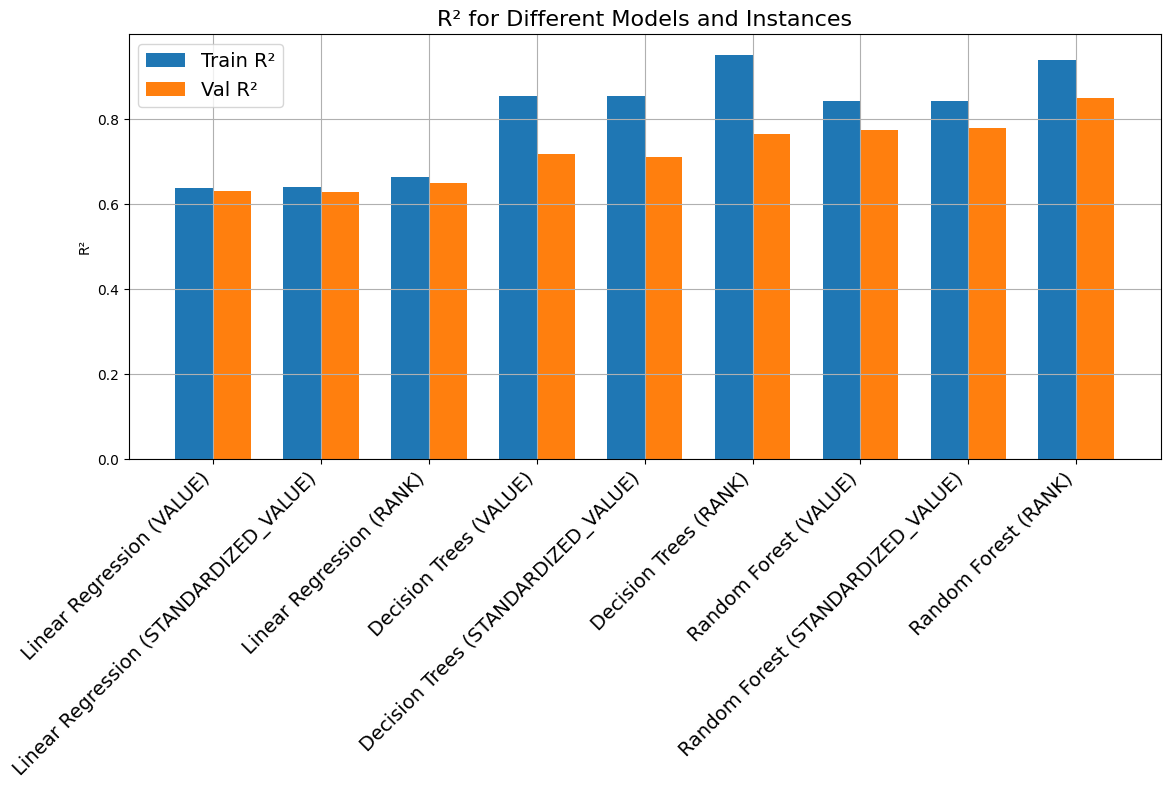

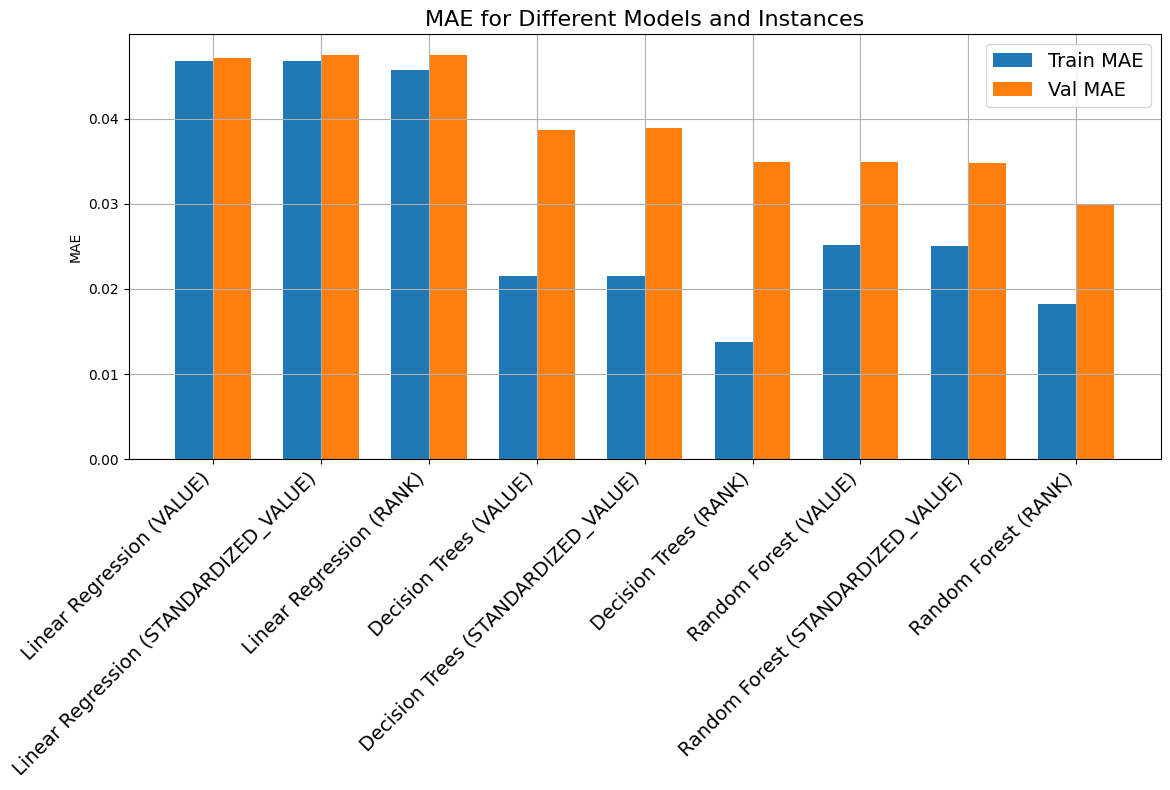

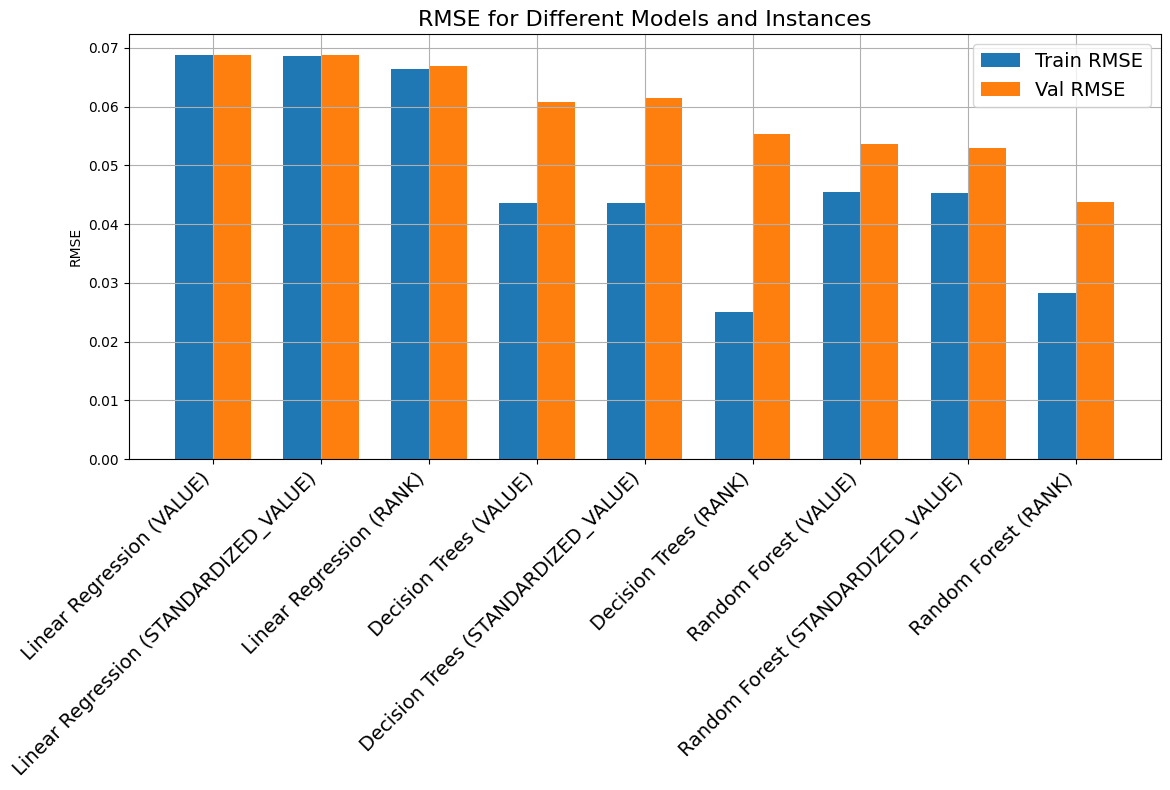

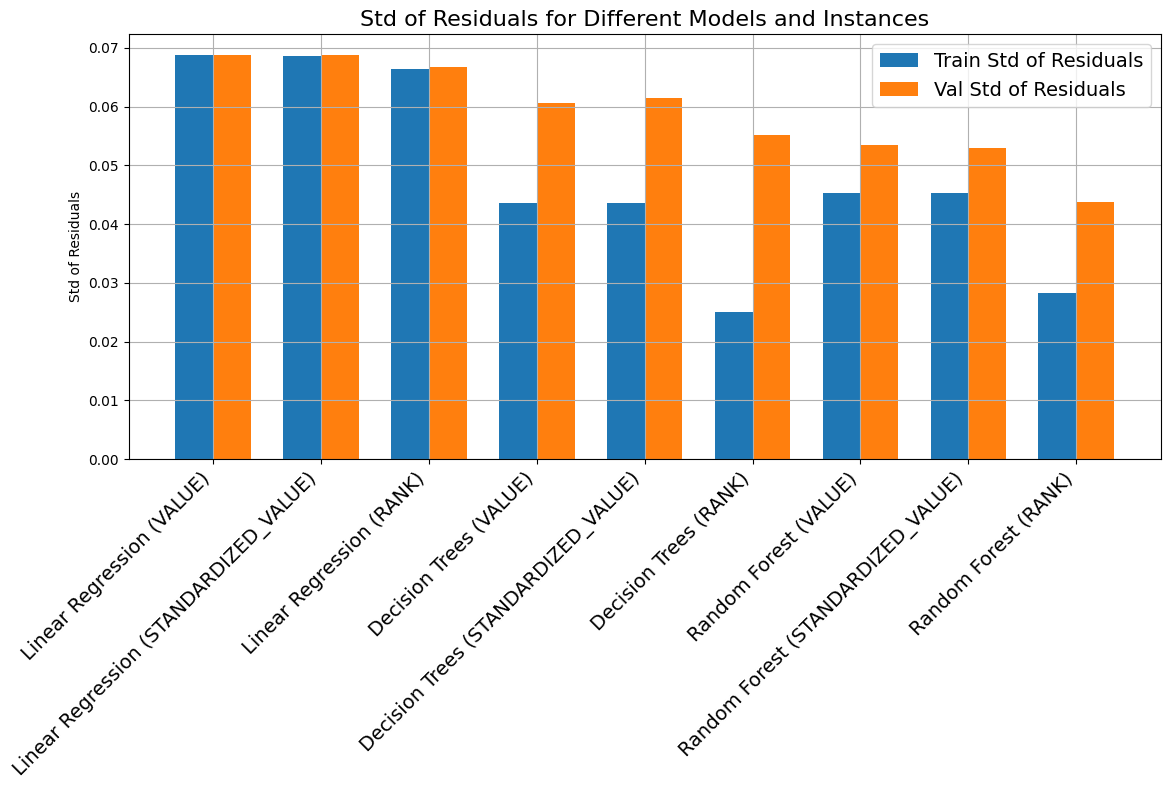

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and their corresponding values in a dictionary
metrics = {
    'R²': {
        'train': [train_r2_value, train_r2_standardized_value, train_r2_rank, train_r2_tree_value, train_r2_tree_standardized_value, train_r2_tree_rank,
                  train_r2_forest_value, train_r2_forest_standardized_value, train_r2_forest_rank],
        'val': [val_r2_value, val_r2_standardized_value, val_r2_rank, val_r2_tree_value, val_r2_tree_standardized_value, val_r2_tree_rank,
                val_r2_forest_value, val_r2_forest_standardized_value, val_r2_forest_rank]
    },
    'MAE': {
        'train': [train_mae_value, train_mae_standardized_value, train_mae_rank, train_mae_tree_value, train_mae_tree_standardized_value, train_mae_tree_rank,
                  train_mae_forest_value, train_mae_forest_standardized_value, train_mae_forest_rank],
        'val': [val_mae_value, val_mae_standardized_value, val_mae_rank, val_mae_tree_value, val_mae_tree_standardized_value, val_mae_tree_rank,
                val_mae_forest_value, val_mae_forest_standardized_value, val_mae_forest_rank]
    },
    'RMSE': {
        'train': [train_rmse_value, train_rmse_standardized_value, train_rmse_rank, train_rmse_tree_value, train_rmse_tree_standardized_value, train_rmse_tree_rank,
                  train_rmse_forest_value, train_rmse_forest_standardized_value, train_rmse_forest_rank],
        'val': [val_rmse_value, val_rmse_standardized_value, val_rmse_rank, val_rmse_tree_value, val_rmse_tree_standardized_value, val_rmse_tree_rank,
                val_rmse_forest_value, val_rmse_forest_standardized_value, val_rmse_forest_rank]
    },
    'Std of Residuals': {
        'train': [train_std_value, train_std_standardized_value, train_std_rank, std_residuals_train_value, std_residuals_train_standardized_value, std_residuals_train_rank,
                  train_std_forest_value, train_std_forest_standardized_value, train_std_forest_rank],
        'val': [val_std_value, val_std_standardized_value, val_std_rank, std_residuals_val_value, std_residuals_val_standardized_value, std_residuals_val_rank,
                val_std_forest_value, val_std_forest_standardized_value, val_std_forest_rank]
    }
}

models = ['Linear Regression (VALUE)', 'Linear Regression (STANDARDIZED_VALUE)', 'Linear Regression (RANK)',
          'Decision Trees (VALUE)', 'Decision Trees (STANDARDIZED_VALUE)', 'Decision Trees (RANK)',
          'Random Forest (VALUE)', 'Random Forest (STANDARDIZED_VALUE)', 'Random Forest (RANK)']

# Define a reusable function for plotting
def plot_metric(metric_name, train_values, val_values, models, file_name):
    values = [train_values, val_values]
    labels = [f'Train {metric_name}', f'Val {metric_name}']

    x = np.arange(len(models))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (val, label) in enumerate(zip(values, labels)):
        ax.bar(x + i * width - width/2, val, width, label=label)

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} for Different Models and Instances', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=14)
    ax.legend(fontsize=14)

    plt.grid(True)
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

# Plot each metric
for metric_name, data in metrics.items():
    plot_metric(metric_name, data['train'], data['val'], models, f'Grouped_Bar_Chart_{metric_name}_Comparison.png')


best model

In [65]:
# Create a dictionary to store model names and their corresponding evaluation metrics
model_metrics = {
    'Model': models,
    'Train_RMSE': metrics['RMSE']['train'],
    'Val_RMSE': metrics['RMSE']['val'],
    'Train_MAE': metrics['MAE']['train'],
    'Val_MAE': metrics['MAE']['val'],
    'Train_R2': metrics['R²']['train'],
    'Val_R2': metrics['R²']['val'],
    'Train_STD': metrics['Std of Residuals']['train'],
    'Val_STD': metrics['Std of Residuals']['val']
}

# Convert the dictionary to a DataFrame for easier manipulation and visualization
metrics_df = pd.DataFrame(model_metrics)

# Sort the DataFrame by the desired metric (e.g., Val_RMSE)
sorted_metrics_df = metrics_df.sort_values(by='Val_RMSE', ascending=True)

# Display the sorted DataFrame
print(sorted_metrics_df)
sorted_metrics_df.to_excel('sorted_metrics_df.xlsx', index=False)
# Based on the sorted DataFrame, choose the best model considering multiple metrics
best_model_index = sorted_metrics_df['Val_RMSE'].idxmin()
best_model_name = sorted_metrics_df.loc[best_model_index, 'Model']

print(f"\nThe best model based on minimal validation RMSE is: {best_model_name}")

                                    Model  Train_RMSE  Val_RMSE  Train_MAE  \
8                    Random Forest (RANK)    0.028248  0.043837   0.018217   
7      Random Forest (STANDARDIZED_VALUE)    0.045263  0.053041   0.025075   
6                   Random Forest (VALUE)    0.045396  0.053569   0.025215   
5                   Decision Trees (RANK)    0.025057  0.055335   0.013716   
3                  Decision Trees (VALUE)    0.043683  0.060768   0.021510   
4     Decision Trees (STANDARDIZED_VALUE)    0.043683  0.061496   0.021510   
2                Linear Regression (RANK)    0.066473  0.066840   0.045679   
0               Linear Regression (VALUE)    0.068869  0.068758   0.046843   
1  Linear Regression (STANDARDIZED_VALUE)    0.068564  0.068813   0.046751   

    Val_MAE  Train_R2    Val_R2  Train_STD   Val_STD  
8  0.029932  0.939151  0.849661   0.028213  0.043704  
7  0.034817  0.843771  0.779901   0.045248  0.052955  
6  0.034894  0.842852  0.775503   0.045380  0.053489  

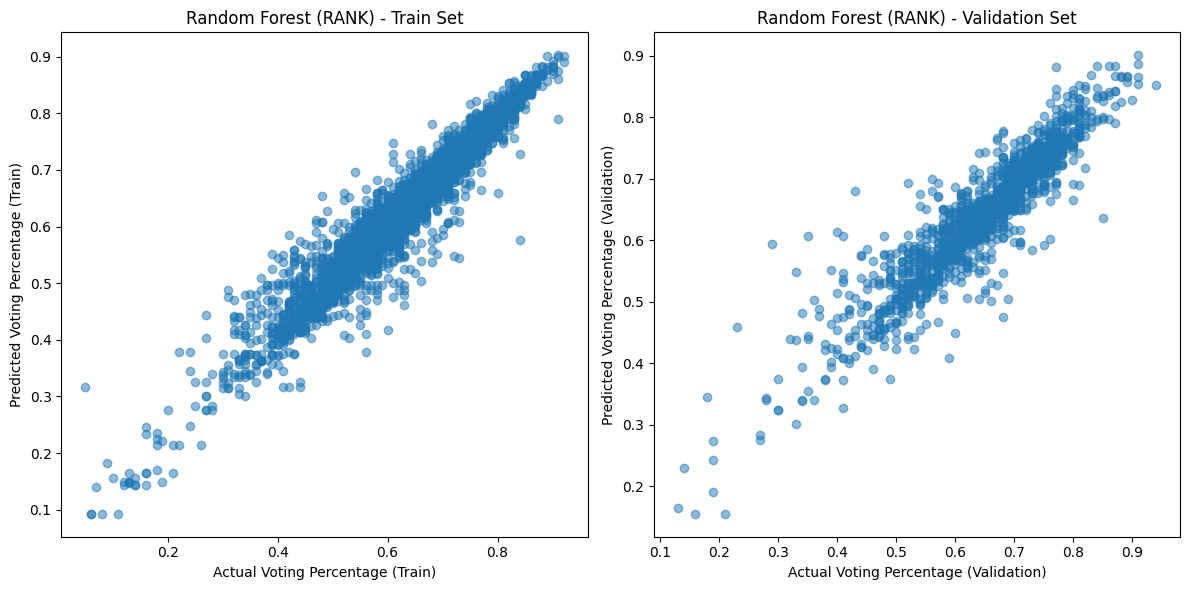

In [66]:
# Predictions on training and validation sets
train_predictions_forest_rank = forest_model_rank.predict(X_rank_train)
val_predictions_forest_rank = forest_model_rank.predict(X_rank_val)

# Scatter plots for predicted vs actual values
plt.figure(figsize=(12, 6))

# Training set plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions_forest_rank, alpha=0.5)
plt.xlabel('Actual Voting Percentage (Train)')
plt.ylabel('Predicted Voting Percentage (Train)')
plt.title('Random Forest (RANK) - Train Set')

# Validation set plot
plt.subplot(1, 2, 2)
plt.scatter(y_val, val_predictions_forest_rank, alpha=0.5)
plt.xlabel('Actual Voting Percentage (Validation)')
plt.ylabel('Predicted Voting Percentage (Validation)')
plt.title('Random Forest (RANK) - Validation Set')

plt.tight_layout()
plt.show()

**Test the Model**

In [67]:
all_columns = test.columns
all_columns = [col for col in all_columns if not col.startswith('_SOCIO_ECONOMIC_INDEX')]
value_columns = [col for col in all_columns if col.endswith('-VALUE')]
standardized_value_columns = [col for col in all_columns if col.endswith('-STANDARDIZED_VALUE')]
rank_columns = [col for col in all_columns if col.endswith('-RANK')]
religion_oneHot = [col for col in all_columns if col.startswith('Religion-_')]

X_rank_test = test[rank_columns + religion_oneHot]

predictions = forest_model_rank.predict(X_rank_test)


predictions_data = test.copy()
predictions_data['Predicted Voting Percentage'] = predictions

# Save the predictions to an Excel file
predictions_data.to_excel('predictions.xlsx')

In [68]:
# Extract actual and predicted values
y_true = predictions_data['Voting precantage']
y_pred = predictions_data['Predicted Voting Percentage']

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
std_residuals = np.std(y_pred - y_true)
# Print the evaluation metrics
print("Regression - Random Forest")
print("Train RMSE\t", round(train_rmse_forest_rank, 3))
print("Test RMSE\t", round(rmse, 3))
print("Train MAE\t", round(train_mae_forest_rank, 3))
print("Test MAE\t", round(mae, 3))
print("Train R2\t", round(train_r2_forest_rank, 3))
print("Test R2\t\t", round(r2, 3))
print("Train STD\t", round(train_std_forest_rank, 3))
print("Test STD\t", round(std_residuals, 3))

Regression - Random Forest
Train RMSE	 0.028
Test RMSE	 0.039
Train MAE	 0.018
Test MAE	 0.027
Train R2	 0.939
Test R2		 0.875
Train STD	 0.028
Test STD	 0.038


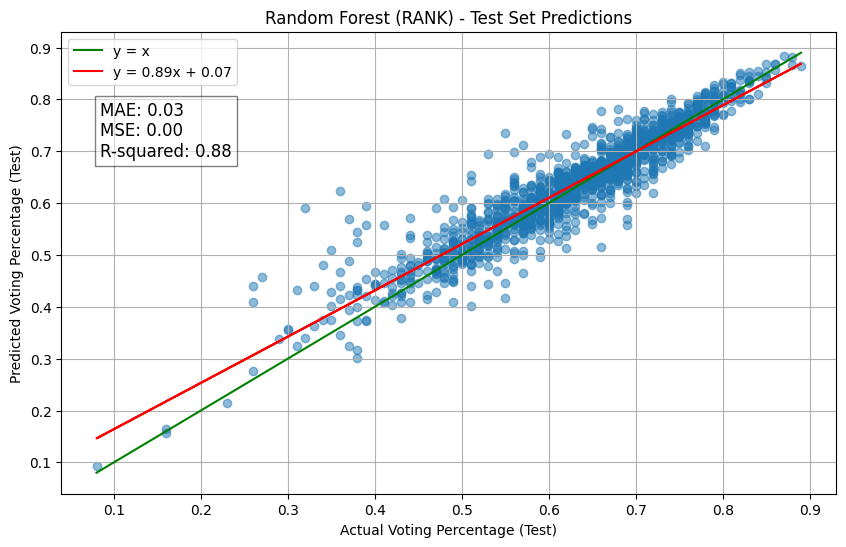

In [69]:
def plot_predictions_vs_actual_with_line(y_true, y_pred, mae, mse, r2, model_name='Model'):
    # Fit a linear regression model to find the best-fit line
    reg = LinearRegression().fit(np.array(y_true).reshape(-1, 1), y_pred)
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # Calculate the line's values
    line = slope * np.array(y_true) + intercept

    # Scatter plot for predicted vs actual values on test data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)

    # Diagonal line indicating perfect predictions (y = x)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='green', label='y = x')

    # Plot the best-fit line
    plt.plot(y_true, line, color='red', label= f'y = {slope:.2f}x + {intercept:.2f}')

    plt.xlabel('Actual Voting Percentage (Test)')
    plt.ylabel('Predicted Voting Percentage (Test)')

    # Display metrics as text on the plot
    plt.text(0.05, 0.85, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nR-squared: {np.ceil(r2 * 100) / 100:.2f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.title(f'{model_name} - Test Set Predictions')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage with Random Forest (RANK)
plot_predictions_vs_actual_with_line(y_true, y_pred, mae, mse, r2, model_name='Random Forest (RANK)')


**Feature Influence Analysis**

                     Group  Importance
0  SCHOOLING_AND_EDUCATION    0.377328
1  EMPLOYMENT_AND_BENEFITS    0.295991
2               DEMOGRAPHY    0.182813
3       STANDARD_OF_LIVING    0.141712
4                 Religion    0.002155


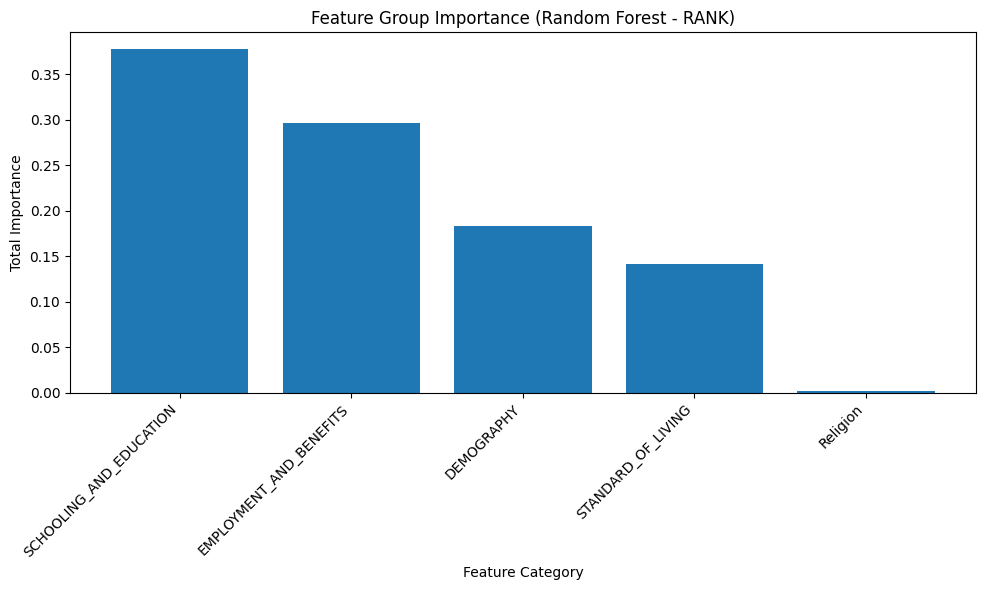

In [70]:
def create_feature_importance_df(model, X):
    feature_importances = model.feature_importances_
    feature_names = X.columns
    feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importances_df['Group'] = feature_importances_df['Feature'].apply(lambda x: x.split('-')[0])
    feature_importances_df['Short Feature Name'] = feature_importances_df['Feature'].apply(lambda x: x.split('-')[1].replace('-RANK', ''))
    feature_importances_df['Short Feature Name'] = feature_importances_df['Short Feature Name'].str.replace('_', ' ')
    feature_importances_df['Short Feature Name'] = feature_importances_df['Short Feature Name'].str.replace('  ', ' ')
    return feature_importances_df

# Create a DataFrame to store feature importances
feature_importances_df = create_feature_importance_df(forest_model_rank, X_rank_train)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Group importances
group_importances_df = feature_importances_df.groupby('Group')['Importance'].sum()

# Sort group importances in descending order
group_importances_df = group_importances_df.sort_values(ascending=False)

# Reset the index to make 'Group' a column
group_importances_df = group_importances_df.reset_index()

# Rename the columns for clarity
group_importances_df.columns = ['Group', 'Importance']
# Print and visualize group importances
print(group_importances_df)

# Plot group importances
plt.figure(figsize=(10, 6))
plt.bar(group_importances_df['Group'], group_importances_df['Importance'])
plt.xlabel('Feature Category')
plt.ylabel('Total Importance')
plt.title('Feature Group Importance (Random Forest - RANK)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

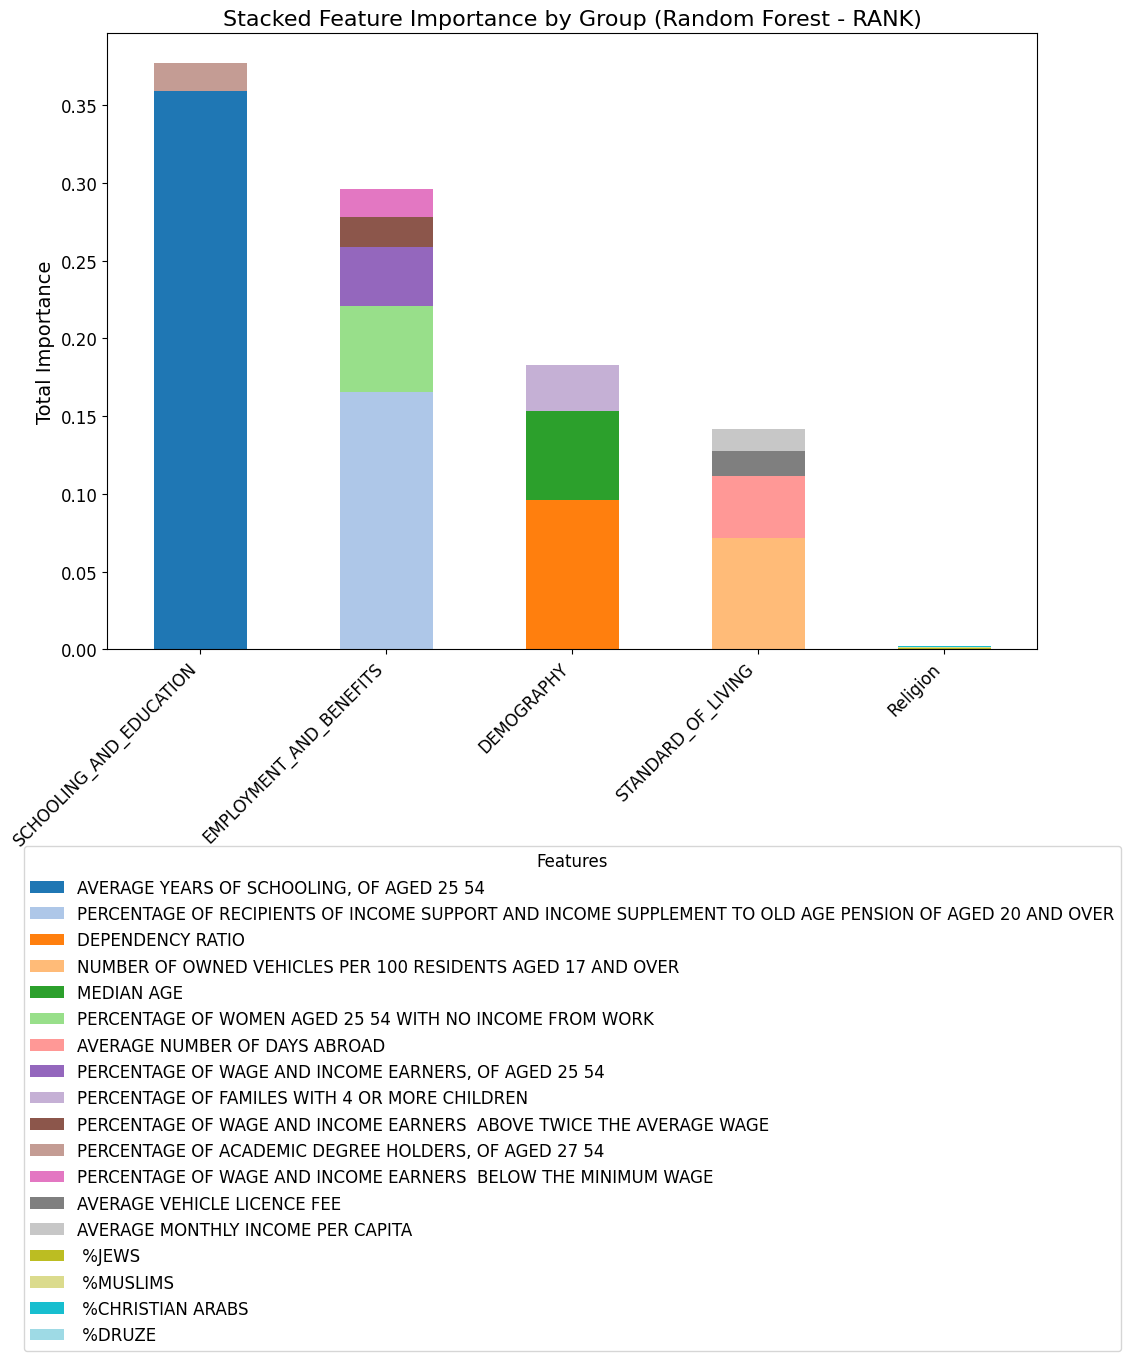

In [71]:
feature_importances_df_dup = feature_importances_df.copy()
importance_order = feature_importances_df_dup.groupby('Short Feature Name')['Importance'].sum().sort_values(ascending=False)
desired_order = importance_order.index.tolist()
feature_importances_df_dup['Short Feature Name'] = pd.Categorical(
    feature_importances_df_dup['Short Feature Name'],
    categories=desired_order,
    ordered=True)
stacked_data = feature_importances_df_dup.pivot(index='Group', columns='Short Feature Name', values='Importance').fillna(0)


# Group by 'Group' and sum the 'Importance' for sorting
grouped = feature_importances_df.groupby('Group').sum().sort_values('Importance', ascending=False)

# Prepare data for stacking
# stacked_data = feature_importances_df.pivot(index='Group', columns='Short Feature Name', values='Importance').fillna(0)

# Sort the data based on total group importance
stacked_data = stacked_data.loc[grouped.index]

# Plot the stacked bar chart
plt.figure(figsize=(12, 8))

# Plot each column as a stacked bar
stacked_data.plot(kind='bar', stacked=True, colormap='tab20', ax=plt.gca())

# Customize the plot
plt.xlabel(None)
plt.ylabel('Total Importance', fontsize=14)
plt.title('Stacked Feature Importance by Group (Random Forest - RANK)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adjust the legend
plt.legend(title='Features',
           loc='upper center',
           bbox_to_anchor=(0.5, -0.305),
           fontsize=12,
           title_fontsize=12)
# plt.tight_layout()

# Show the plot
plt.show()


In [72]:
# prompt: check Statistical significance for each feature based on the forest rank model

import pandas as pd
from sklearn.feature_selection import f_regression

# Perform F-test for feature significance
f_statistic, p_values = f_regression(X_rank_test, y_pred)

# Create a DataFrame to store results
significance_df = pd.DataFrame({
    'Feature': X_rank_train.columns,
    'F-statistic': f_statistic,
    'p-value': p_values
})

# Determine significance based on a threshold (e.g., 0.05)
alpha = 0.05
significance_df['Significant'] = significance_df['p-value'] < alpha

# Print the results
print(significance_df.sort_values('p-value'))


                                              Feature  F-statistic  \
9   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIEN...  1022.352195   
3   SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOO...   834.772699   
6   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AG...   660.738932   
7   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...   494.522909   
11  STANDARD_OF_LIVING-NUMBER_OF_OWNED_VEHICLES_PE...   494.365838   
12  STANDARD_OF_LIVING-AVERAGE_VEHICLE_LICENCE_FEE...   325.245244   
5   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...   316.652462   
8   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...   290.558129   
10  STANDARD_OF_LIVING-AVERAGE_MONTHLY_INCOME_PER_...   251.343699   
4   SCHOOLING_AND_EDUCATION-PERCENTAGE_OF_ACADEMIC...   237.329711   
16                                    Religion-_%JEWS   162.370774   
17                                 Religion-_%MUSLIMS   124.215146   
1                    DEMOGRAPHY-DEPENDENCY_RATIO-RANK   112.129188   
0                   

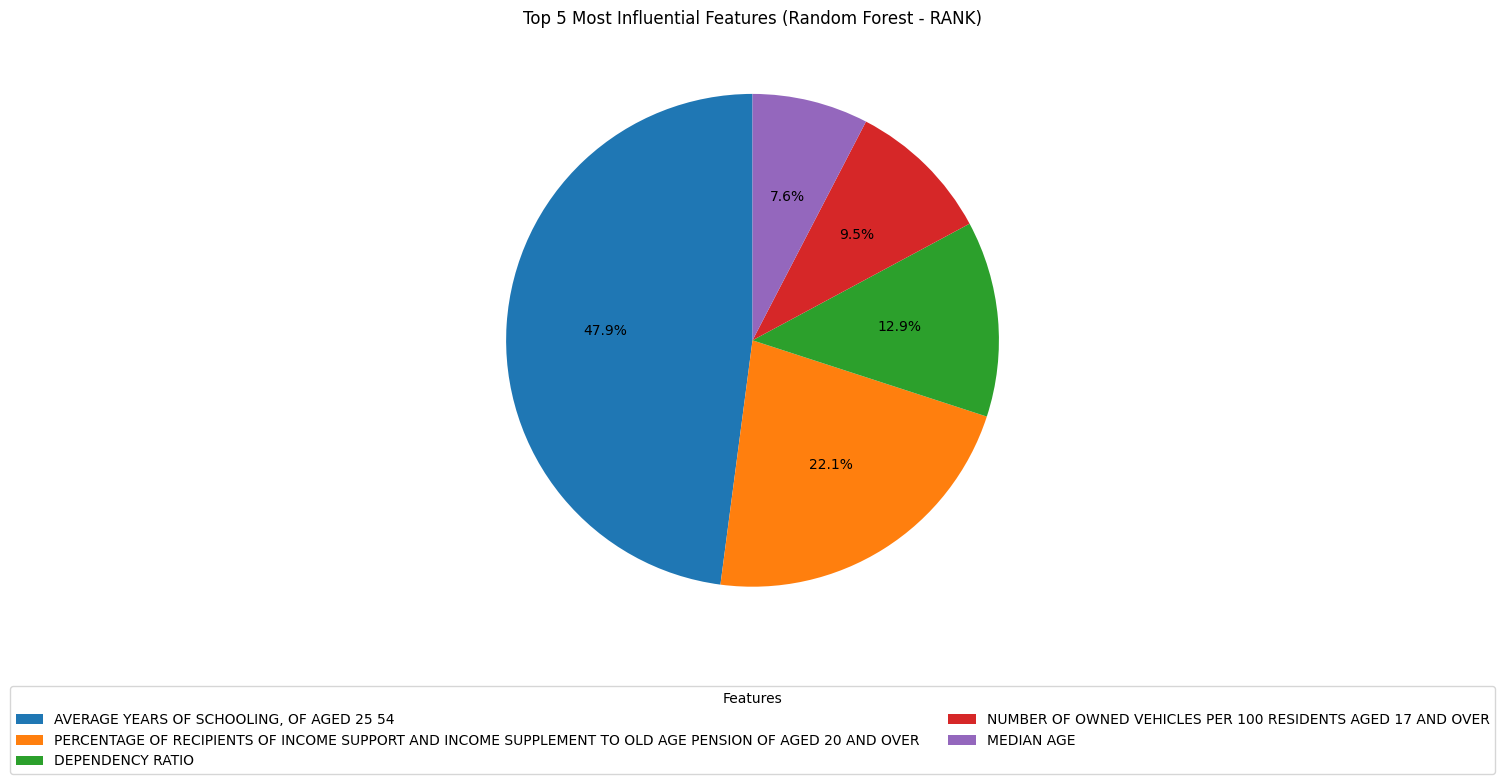

In [73]:
# Select the top 5 features
top_5_features = feature_importances_df.head(5)

# Plot the top 5 features as a pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    top_5_features['Importance'],
    labels=None,
    autopct='%1.1f%%',
    startangle=90)
plt.legend(wedges, top_5_features['Short Feature Name'], title="Features", loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.setp(autotexts, size=10)
plt.title('Top 5 Most Influential Features (Random Forest - RANK)')
# plt.tight_layout()
plt.show()


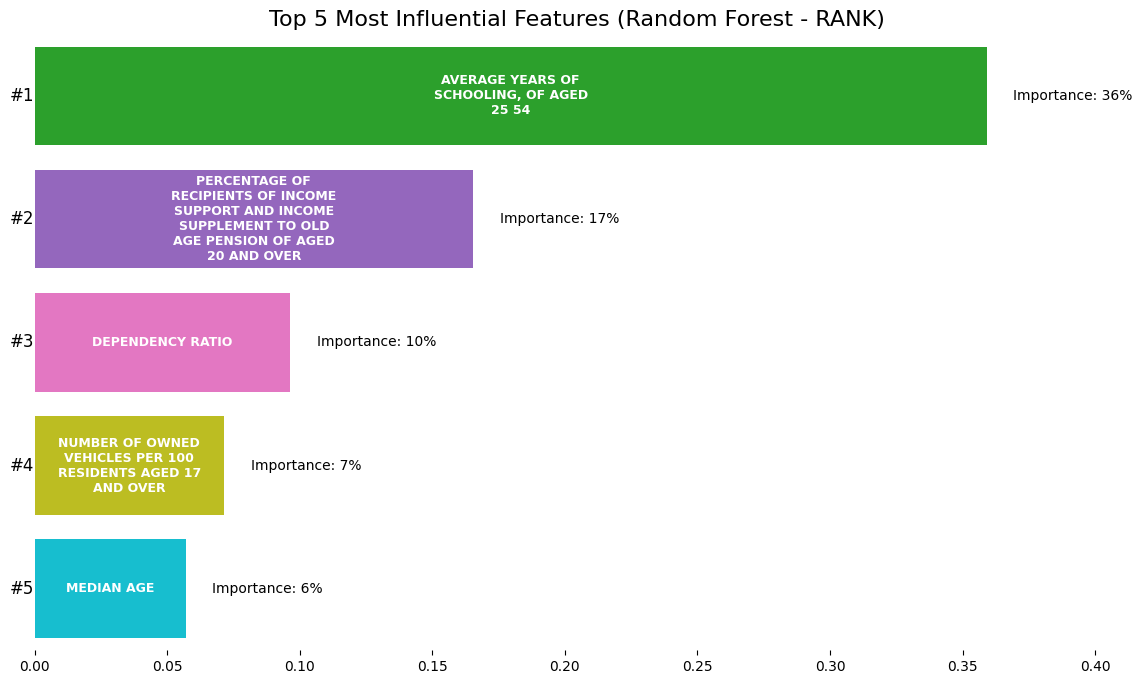

In [74]:
# Plotting
plt.figure(figsize=(14, 8))  # Increased figure size for more space
ax = plt.gca()

# Set background color
# ax.set_facecolor('lightgray')

# Remove the plot frame (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Iterate over each feature and plot a rectangle for it
bar_height = 0.8  # Increase bar height for more space
for i, (feature, importance) in enumerate(zip(top_5_features['Short Feature Name'], top_5_features['Importance']), 1):
    wrapped_feature = "\n".join(textwrap.wrap(feature, width=20))  # Adjust wrapping width
    plt.barh(i, importance, color=plt.cm.tab10(i / len(top_5_features)), edgecolor='none', height=bar_height)
    plt.text(importance / 2, i, f'{wrapped_feature}', va='center', ha='center', fontsize=9, color='w', weight='bold')
    plt.text(importance + 0.01, i, f'Importance: {importance * 100:.0f}%', va='center', ha='left', fontsize=10, color='black')

# Add the ranking numbers to each bar
for i in range(len(top_5_features)):
    plt.text(0, i+1, f'#{i+1}', va='center', ha='right', fontsize=12, color='black')

# Customize the plot
plt.yticks([])  # Remove y-ticks
plt.xlim(0, max(top_5_features['Importance']) + 0.05)  # Set x-limit
plt.ylim(0.5, len(top_5_features) + 0.5)  # Set y-limit
plt.title('Top 5 Most Influential Features (Random Forest - RANK)', fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.grid(False)  # Remove the grid

# Show the plot
plt.show()


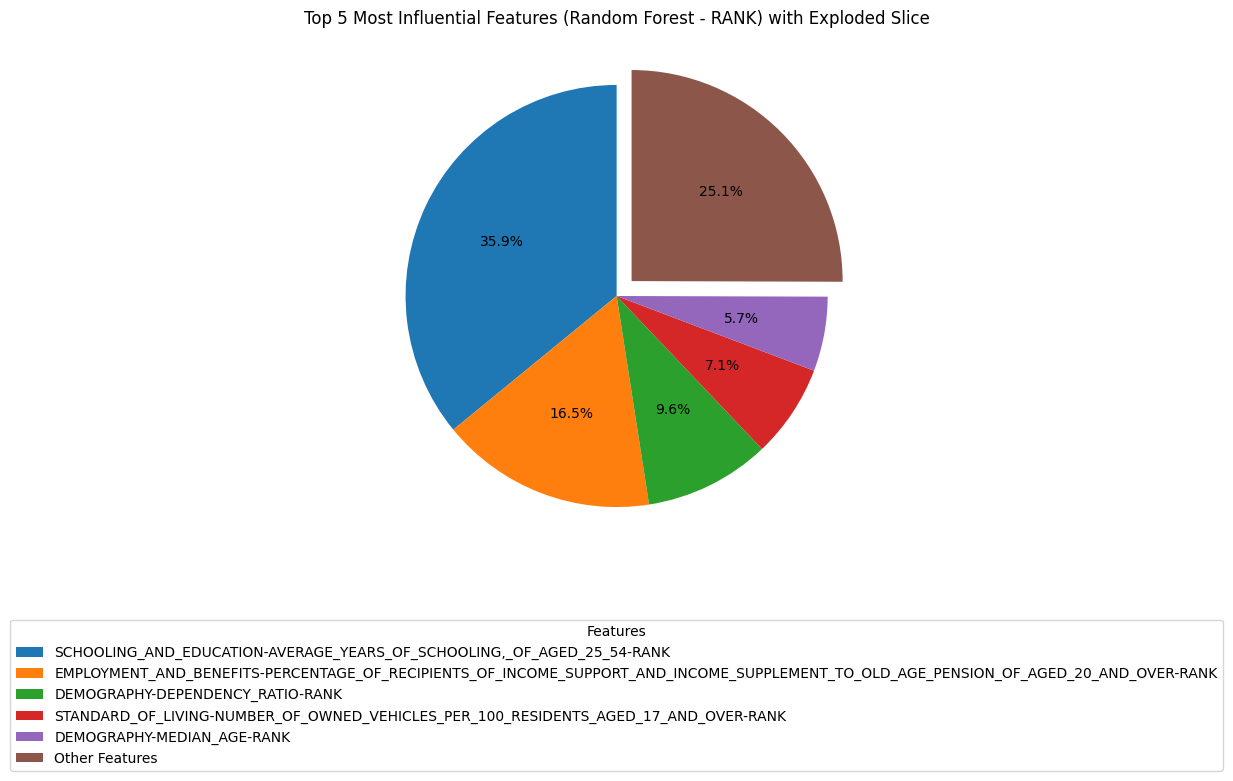

In [75]:
import matplotlib.pyplot as plt

# Identify the top 5 features
top_5_features = top_5_features.sort_values(by='Importance', ascending=False)
top_5_features = top_5_features.head(5)

# Calculate the "Rest" of the features
rest_importance = 1 - top_5_features['Importance'].sum()
rest_features = pd.DataFrame({'Feature': ['Other Features'], 'Importance': [rest_importance]})

# Combine the top 5 features with the rest
combined_features = pd.concat([top_5_features, rest_features])

# Create the exploding pie chart
explode = [0] * 5 + [0.1]  # Explode the last slice (the "Rest" slice)

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    combined_features['Importance'],
    labels=None,  # No labels on the pie
    autopct='%1.1f%%',
    startangle=90,
    explode=explode
)

# Add a legend below the pie chart
plt.legend(wedges, combined_features['Feature'], title="Features", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=1)

# Customize the plot
plt.setp(autotexts, size=10)
plt.title('Top 5 Most Influential Features (Random Forest - RANK) with Exploded Slice')
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-76-da5c5a58dff8>:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.5 - 0.1*(5-i), y), 0.2*(5-i), 0.2, color=color, edgecolor='black')


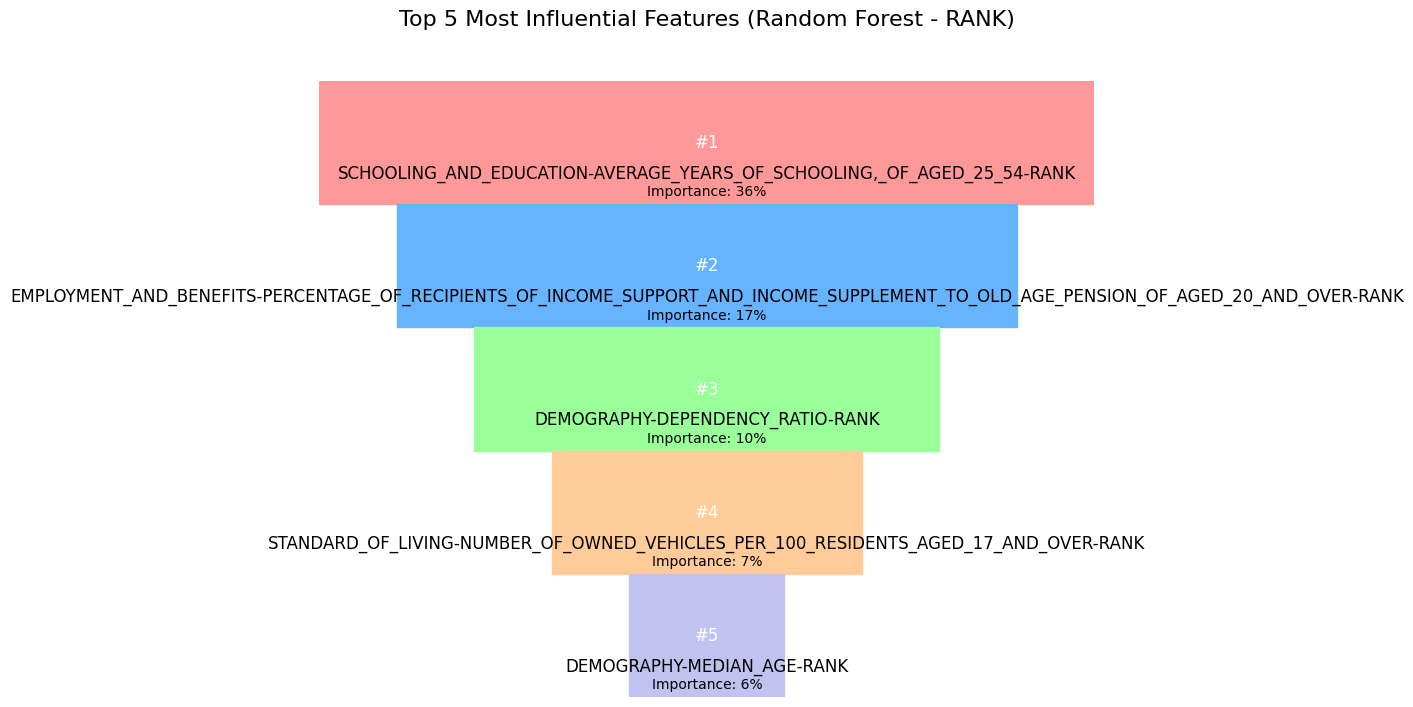

<ipython-input-76-da5c5a58dff8>:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.5 - 0.1*(3-i), y), 0.2*(3-i), 0.2, color=color, edgecolor='black')


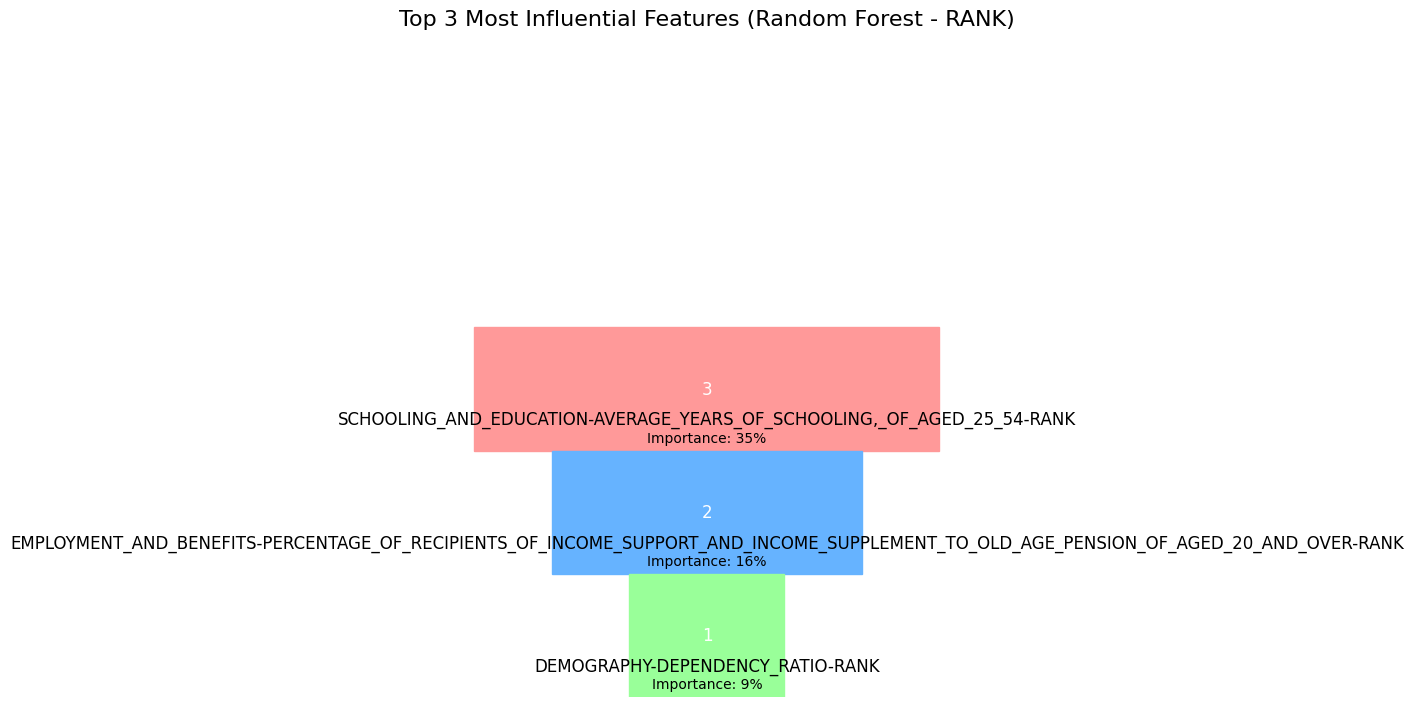

In [76]:

# Get feature importances from the trained Random Forest model
importances = forest_model_rank.feature_importances_

# Get feature names from the DataFrame
feature_names = X_rank.columns

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top 5 features
top_5_features = feature_importances_df.head(5)

# Extract feature names and importance values
features = top_5_features['Feature'].tolist()
importances = top_5_features['Importance'].tolist()

# Create a pyramid plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')  # Turn off the axis

# Define the pyramid layers
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
y_positions = [0.8, 0.6, 0.4, 0.2, 0.0]

# Plot each layer
for i, (feature, importance, color, y) in enumerate(zip(features, importances, colors, y_positions)):
    rect = Rectangle((0.5 - 0.1*(5-i), y), 0.2*(5-i), 0.2, color=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(0.5, y + 0.1, f'#{i+1}', fontsize=12, ha='center', va='center', color='white')
    ax.text(0.5, y + 0.05, feature, fontsize=12, ha='center', va='center', color='black')
    ax.text(0.5, y + 0.02, f'Importance: {int(round(importance * 100))}%', fontsize=10, ha='center', va='center', color='black')

# Set plot title with more padding
plt.title('Top 5 Most Influential Features (Random Forest - RANK)', fontsize=16, pad=40)

# Show the plot
plt.show()

# Select the top 3 features
top_3_features = feature_importances_df.head(3)

# Extract feature names and importance values
features = top_3_features['Feature'].tolist()
importances = top_3_features['Importance'].tolist()

# Convert importances to percentages and then to integers
importances = [int(imp * 100) for imp in importances]

# Create a pyramid plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')  # Turn off the axis

# Define the pyramid layers
colors = ['#ff9999','#66b3ff','#99ff99']
y_positions = [0.4, 0.2, 0.0]

# Plot each layer
for i, (feature, importance, color, y) in enumerate(zip(features, importances, colors, y_positions)):
    rect = Rectangle((0.5 - 0.1*(3-i), y), 0.2*(3-i), 0.2, color=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(0.5, y + 0.1, f'{3-i}', fontsize=12, ha='center', va='center', color='white')
    ax.text(0.5, y + 0.05, feature, fontsize=12, ha='center', va='center', color='black')
    ax.text(0.5, y + 0.02, f'Importance: {importance}%', fontsize=10, ha='center', va='center', color='black')

# Set plot title with more padding
plt.title('Top 3 Most Influential Features (Random Forest - RANK)', fontsize=16, pad=40)

# Show the plot
plt.show()



In [77]:
# Train a baseline Random Forest model with all features
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_rank_train, y_train)
baseline_pred = baseline_model.predict(X_rank_test)
baseline_rmse = mean_squared_error(y_true, baseline_pred, squared=False)
baseline_r2 = r2_score(y_true, baseline_pred)
baseline_std_residuals = np.std(y_true - baseline_pred)

print(f'Baseline RMSE: {baseline_rmse}')
print(f'Baseline R²: {baseline_r2}')
print(f'Baseline Std of Residuals: {baseline_std_residuals}')

results = []

for feature in X_rank_train.columns:
    # Drop the feature from the dataset
    X_train_drop = X_rank_train.drop(columns=[feature])
    X_test_drop = X_rank_test.drop(columns=[feature])

    # Train the model without this feature
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_drop, y_train)
    pred = model.predict(X_test_drop)
    rmse = mean_squared_error(y_true, pred, squared=False)
    r2 = r2_score(y_true, pred)
    std_residuals = np.std(y_true - pred)

    # Append the results to the list
    results.append({
        'Feature': feature,
        'RMSE': rmse,
        'R²': r2,
        'Std of Residuals': std_residuals,
        'RMSE Change': rmse - baseline_rmse,
        'R² Change': r2 - baseline_r2,
        'Std Residuals Change': std_residuals - baseline_std_residuals
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print("\nResults after removing each feature:")
print(results_df)


Baseline RMSE: 0.03880602130029682
Baseline R²: 0.8754295218635634
Baseline Std of Residuals: 0.03820573127887512

Results after removing each feature:
                                              Feature      RMSE        R²  \
0                          DEMOGRAPHY-MEDIAN_AGE-RANK  0.038974  0.874346   
1                    DEMOGRAPHY-DEPENDENCY_RATIO-RANK  0.038712  0.876034   
2   DEMOGRAPHY-PERCENTAGE_OF_FAMILES_WITH_4_OR_MOR...  0.038687  0.876194   
3   SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOO...  0.038450  0.877706   
4   SCHOOLING_AND_EDUCATION-PERCENTAGE_OF_ACADEMIC...  0.038874  0.874991   
5   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...  0.038919  0.874705   
6   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AG...  0.038638  0.876506   
7   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...  0.038642  0.876480   
8   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...  0.038795  0.875499   
9   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIEN...  0.038783  0.875579   
1